# Neural Network Model


<h4><u>Sections:</u></h4>

<ul>
    <li>Introductory Notes</li>
</ul>
<ol>
    <li>Imports & Settings</li>
    <li>Data Loads & Transforms</li>
    <li>Model Build & Training</li>
    <li>Model Recall & Evaluation</li>
    <ol>
            <li>General View of Prediction Behavior</li>
            <li>Comparison to Baseline</li>
    </ol>
    <li>Model Explanation Using SHAP</li>
<ol>
    
    
    
    
---

<u><strong>Introductory Notes</strong></u>

Why not LSTM?
- I expect LSTM may perform better--I intend to try it and compare results. I started with NN for three reasons:
    - I was curious to examine the effect of discrete trailing features in the time series (example, previous 30-day mean WTI price) independently of the continuous time series itself.
    - I'm more familiar (or was when I started this) with NN architecture, and wanted to use a successful NN as a baseline for future LSTM modeling.
    - I like the idea of the test dataset being randomly distributed across the time span (that span representing a variety of socio-economic exogeneities not captured in the feature set).
    
Knowing the future...
- I use a couple forward-looking parameters related to GDP in the model, which may seem to defy logic a bit (we can only make predictions based on parameters known <i>at the time of estimation</i>). Here's my reasoning: energy demand relates to overall economic activity, measured as GDP, and GDP is forecast with fair reliability by the Organization for Economic Cooperation and Development (OECD). However, I have yet to find a data source for <i>historical forecasts</i>. Therefore, the <i>actual</i> forward-looking GDP values serve as a proxy for GDP forecasts. For a forecast made today, we would enter the OECD's forecast estimate for these features.

---
## 1. Imports & Settings:
---

In [1]:
# standard library imports:

import os


# package imports:

import pandas as pd
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

import shap

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# general settings:

sns.set()

plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['figure.dpi'] = 300

shap.initjs()

---
## 2. Data Loads & Transformations:
---

In [3]:
# load the csv data prepared & exported by 'data_load_transform_EDA.ipynb'

df = pd.read_csv('predict_WTI.csv', index_col=0)

df

price  t90d_mean  t30d_mean  f30d_mean  US Production  storage  \
1990-01-01  21.84  20.387000  21.151000  22.904667           7565   904134   
1990-01-02  22.88  20.417111  21.238333  22.933000           7565   904134   
1990-01-03  23.81  20.460000  21.357333  22.927333           7565   904134   
1990-01-04  23.41  20.499111  21.463667  22.901667           7565   904134   
1990-01-05  23.07  20.534444  21.550667  22.889333           7512   904076   
...           ...        ...        ...        ...            ...      ...   
2021-10-14  81.43  71.349222  75.840333  82.745000          11400  1043945   
2021-10-15  82.39  71.467333  76.167000  82.726333          11300  1041820   
2021-10-16  82.39  71.585444  76.490333  82.675667          11300  1041820   
2021-10-17  82.39  71.762556  76.833667  82.624333          11300  1041820   
2021-10-18  82.62  71.932556  77.184667  82.570000          11300  1041820   

                     gdp  f30d_mean_gdp  f365d_mean_gdp  
1990-01-01   9340.478778    9352.766670     9368.661736  
1990-01-02   9341.326219    9353.614111     9368.475865  
1990-01-03   9342.173660    9354.461552     9368.287526  
1990-01-04   9343.021100    9355.303125     9368.096719  
1990-01-05   9343.868541    9356.138830     9367.903444  
...                  ...            ...             ...  
2021-10-14  19617.739033   19653.189860    20048.135191  
2021-10-15  19620.178531   19655.643559    20050.372550  
2021-10-16  19622.618029   19658.098442    20052.607767  
2021-10-17  19625.057527   19660.554507    20054.840844  
2021-10-18  19627.497025   19663.011756    20057.071779  

[11613 rows x 9 columns]

In [4]:
# reduce the data for modeling a more recent period, and
# split into input (X) and output (y) datasets:

X = df.reset_index(drop=True).drop('f30d_mean', axis=1)
y = df['f30d_mean'].reset_index(drop=True)

In [5]:
X

price  t90d_mean  t30d_mean  US Production  storage           gdp  \
0      21.84  20.387000  21.151000           7565   904134   9340.478778   
1      22.88  20.417111  21.238333           7565   904134   9341.326219   
2      23.81  20.460000  21.357333           7565   904134   9342.173660   
3      23.41  20.499111  21.463667           7565   904134   9343.021100   
4      23.07  20.534444  21.550667           7512   904076   9343.868541   
...      ...        ...        ...            ...      ...           ...   
11608  81.43  71.349222  75.840333          11400  1043945  19617.739033   
11609  82.39  71.467333  76.167000          11300  1041820  19620.178531   
11610  82.39  71.585444  76.490333          11300  1041820  19622.618029   
11611  82.39  71.762556  76.833667          11300  1041820  19625.057527   
11612  82.62  71.932556  77.184667          11300  1041820  19627.497025   

       f30d_mean_gdp  f365d_mean_gdp  
0        9352.766670     9368.661736  
1        9353.614111     9368.475865  
2        9354.461552     9368.287526  
3        9355.303125     9368.096719  
4        9356.138830     9367.903444  
...              ...             ...  
11608   19653.189860    20048.135191  
11609   19655.643559    20050.372550  
11610   19658.098442    20052.607767  
11611   19660.554507    20054.840844  
11612   19663.011756    20057.071779  

[11613 rows x 8 columns]

In [6]:
y

0        22.904667
1        22.933000
2        22.927333
3        22.901667
4        22.889333
           ...    
11608    82.745000
11609    82.726333
11610    82.675667
11611    82.624333
11612    82.570000
Name: f30d_mean, Length: 11613, dtype: float64

In [7]:
# create the train-test split:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scal = RobustScaler()

X_train = scal.fit_transform(X_train)
X_test = scal.transform(X_test)

In [8]:
# examine X and y shapes:

print('X shape: ' + str(X.shape))
print('y shape: ' + str(y.shape))
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))

X shape: (11613, 8)
y shape: (11613,)
X_train shape: (8129, 8)
y_train shape: (8129,)


---
## 3. Model Build & Training: 
---

In [9]:
choice = input('Enter your choice (enter the number):\n 1: Train a new model\n 2: Skip training and load the existing best model')

Enter your choice (enter the number):
 1: Train a new model
 2: Skip training and load the existing best model2


In [10]:
if choice == 1:
    # build the neural network:

    mod = Sequential()

    mod.add(Dense(128, activation='relu'))
    mod.add(Dense(128, activation='relu'))
    mod.add(Dense(128, activation='relu'))
    mod.add(Dense(1))

    mod.compile(optimizer='adam', loss='mse')


    # set up early stopping:
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # set up checkpoints to recall the best model:
    model_cp = tf.keras.callbacks.ModelCheckpoint('models_best_nn.h5', monitor='val_loss', verbose=1, save_best_only=True)

    # train the NN:

    mod.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=[early_stop, model_cp], verbose=0)

    # view the history of model loss & validation loss:

    history = pd.DataFrame(mod.history.history).plot()
    history

    plt.ylim(0, 20)

---
## 4. Model Recall & Evaluation:

#### A. General View of Prediction Behavior
---

In [11]:
# recall the best model:
mod = tf.keras.models.load_model('models_best_nn.h5')

(0.0, 145.78884999999997)

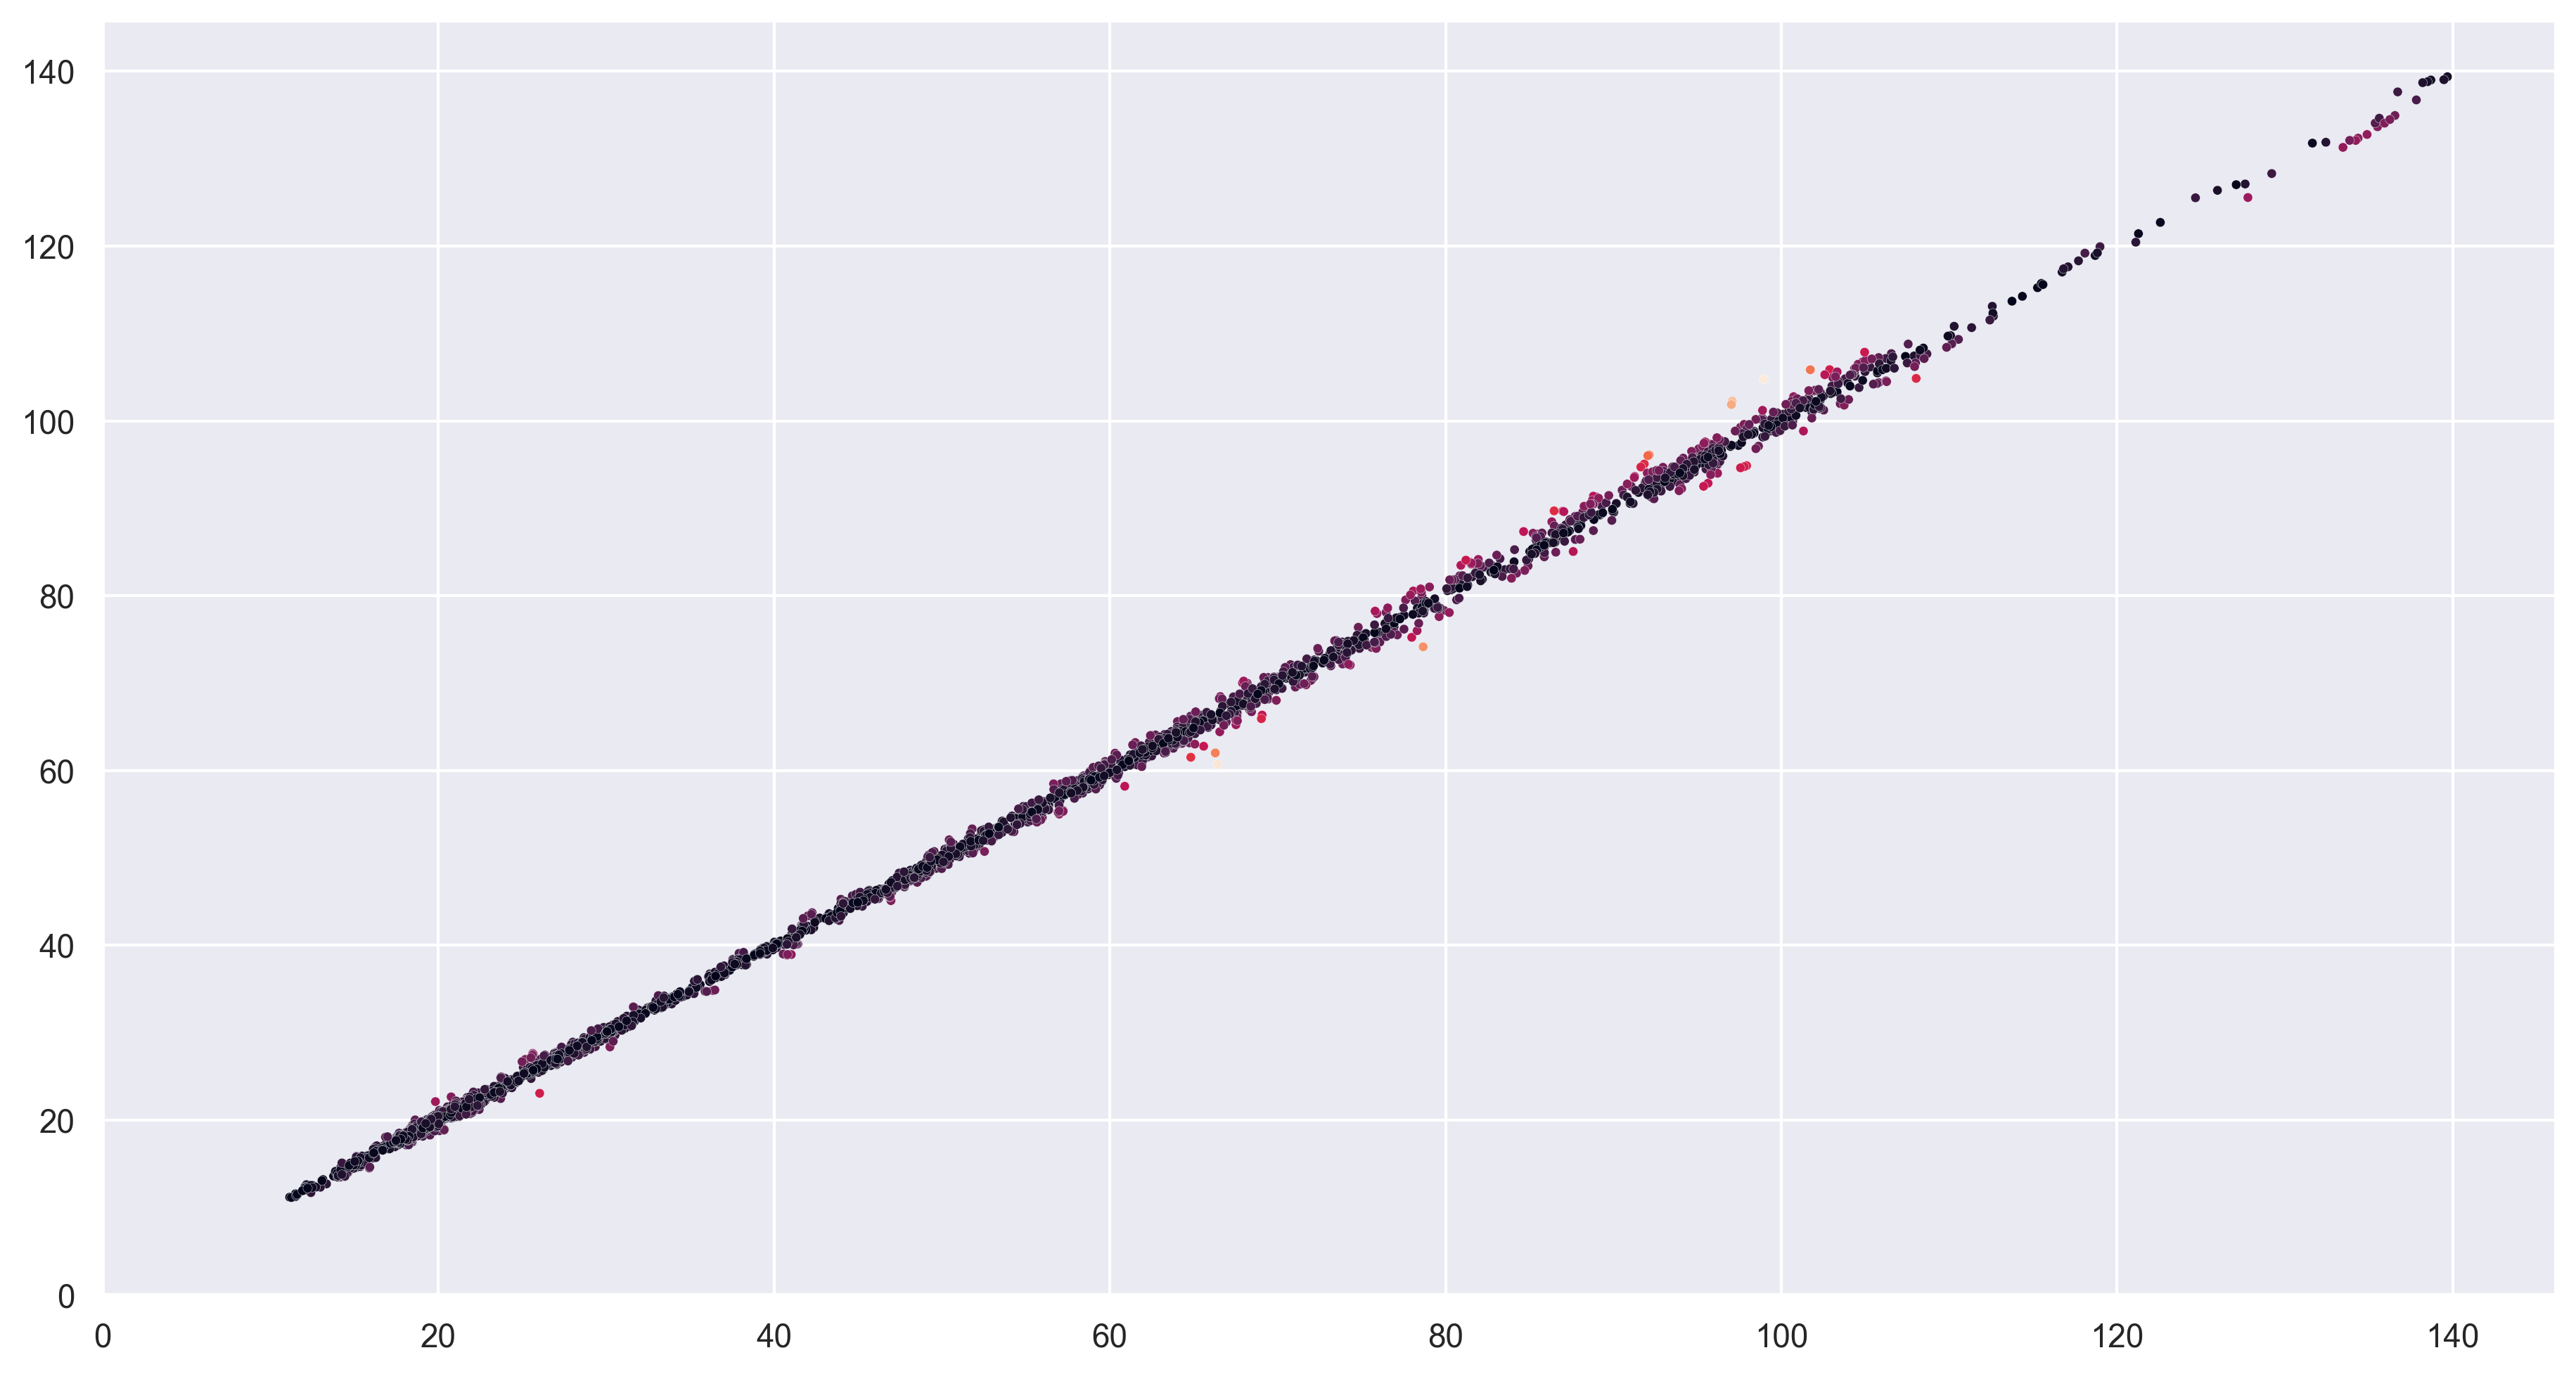

In [12]:
# create and view predictions versus actual (test data only):

predictions = mod.predict(X_test).reshape(y_test.shape)

plt.scatter(predictions, y_test, s=10, c=abs(y_test-predictions), edgecolors='w', linewidth=.1)
plt.xlim(0,)
plt.ylim(0,)

In [13]:
# create a "model view" (mv) dataframe:

mv = df.copy()
mv['NN_pred'] = mod.predict(scal.transform(df[X.columns].values))
mv

price  t90d_mean  t30d_mean  f30d_mean  US Production  storage  \
1990-01-01  21.84  20.387000  21.151000  22.904667           7565   904134   
1990-01-02  22.88  20.417111  21.238333  22.933000           7565   904134   
1990-01-03  23.81  20.460000  21.357333  22.927333           7565   904134   
1990-01-04  23.41  20.499111  21.463667  22.901667           7565   904134   
1990-01-05  23.07  20.534444  21.550667  22.889333           7512   904076   
...           ...        ...        ...        ...            ...      ...   
2021-10-14  81.43  71.349222  75.840333  82.745000          11400  1043945   
2021-10-15  82.39  71.467333  76.167000  82.726333          11300  1041820   
2021-10-16  82.39  71.585444  76.490333  82.675667          11300  1041820   
2021-10-17  82.39  71.762556  76.833667  82.624333          11300  1041820   
2021-10-18  82.62  71.932556  77.184667  82.570000          11300  1041820   

                     gdp  f30d_mean_gdp  f365d_mean_gdp    NN_pred  
1990-01-01   9340.478778    9352.766670     9368.661736  22.017687  
1990-01-02   9341.326219    9353.614111     9368.475865  22.795509  
1990-01-03   9342.173660    9354.461552     9368.287526  23.292566  
1990-01-04   9343.021100    9355.303125     9368.096719  23.127172  
1990-01-05   9343.868541    9356.138830     9367.903444  22.723604  
...                  ...            ...             ...        ...  
2021-10-14  19617.739033   19653.189860    20048.135191  83.057686  
2021-10-15  19620.178531   19655.643559    20050.372550  84.281700  
2021-10-16  19622.618029   19658.098442    20052.607767  84.234459  
2021-10-17  19625.057527   19660.554507    20054.840844  84.162079  
2021-10-18  19627.497025   19663.011756    20057.071779  84.227608  

[11613 rows x 10 columns]

<AxesSubplot:>

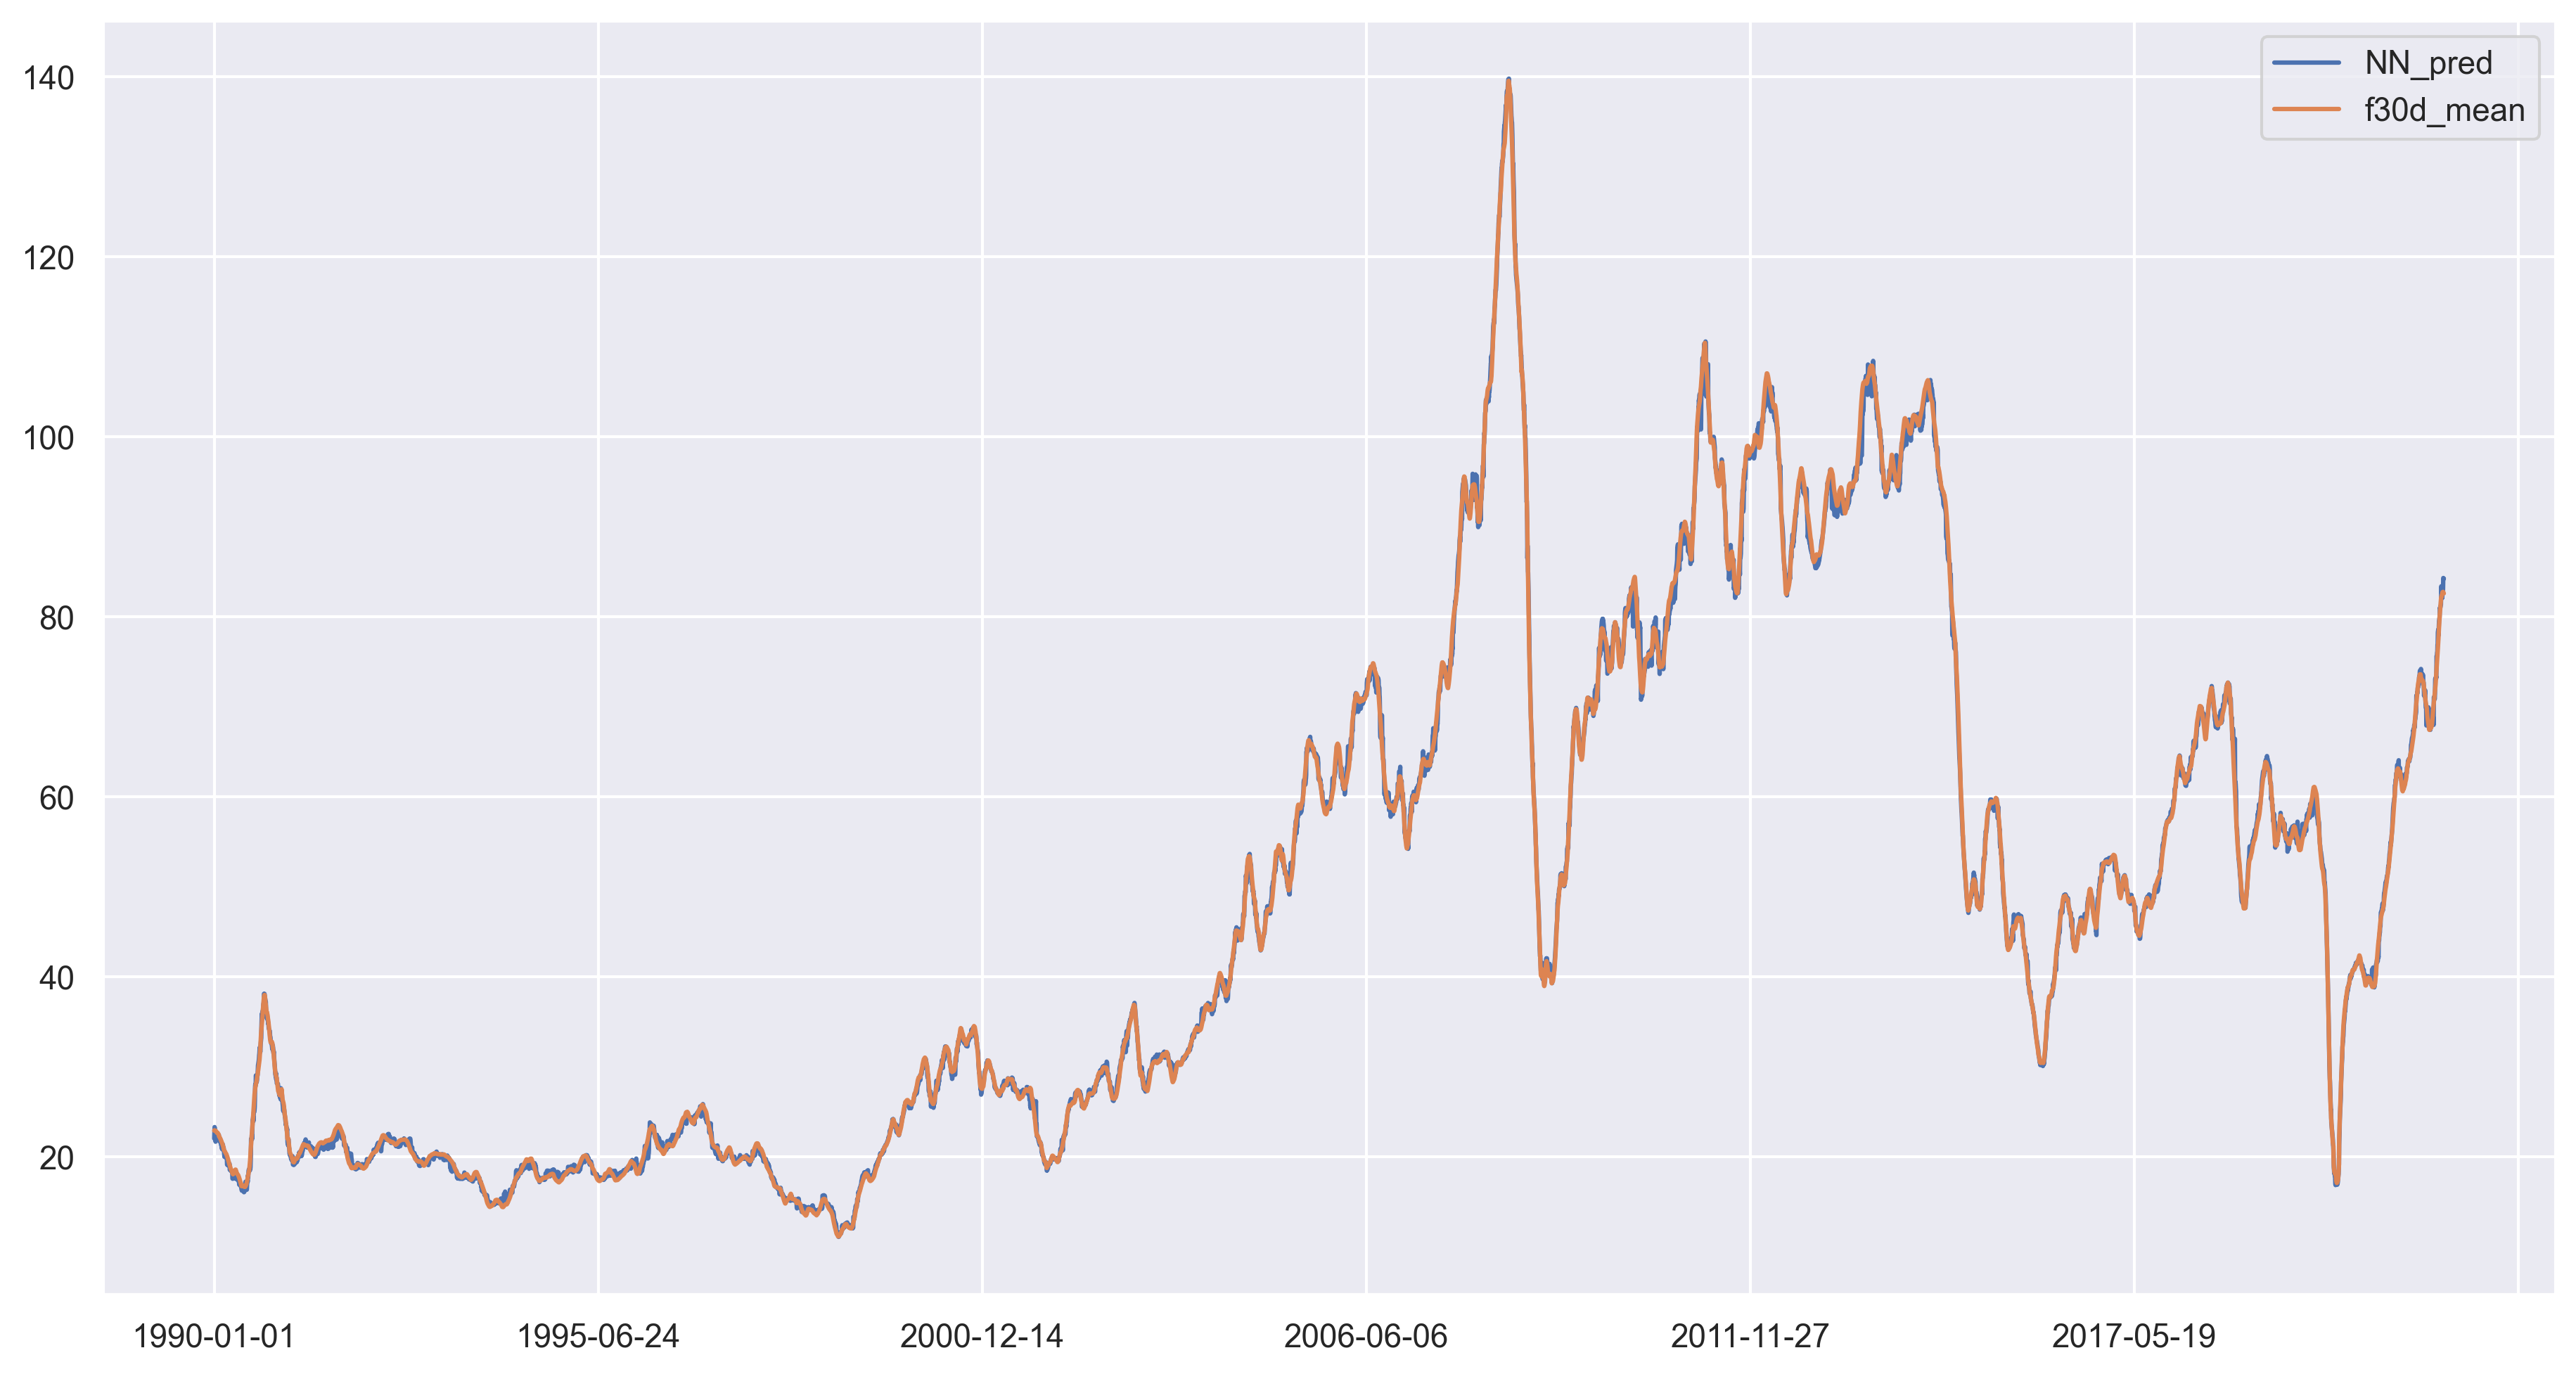

In [14]:
# general visualization of overall model fit
# includes train + test data:

mv[['NN_pred', 'f30d_mean']].plot(figsize=(15,8))

<AxesSubplot:>

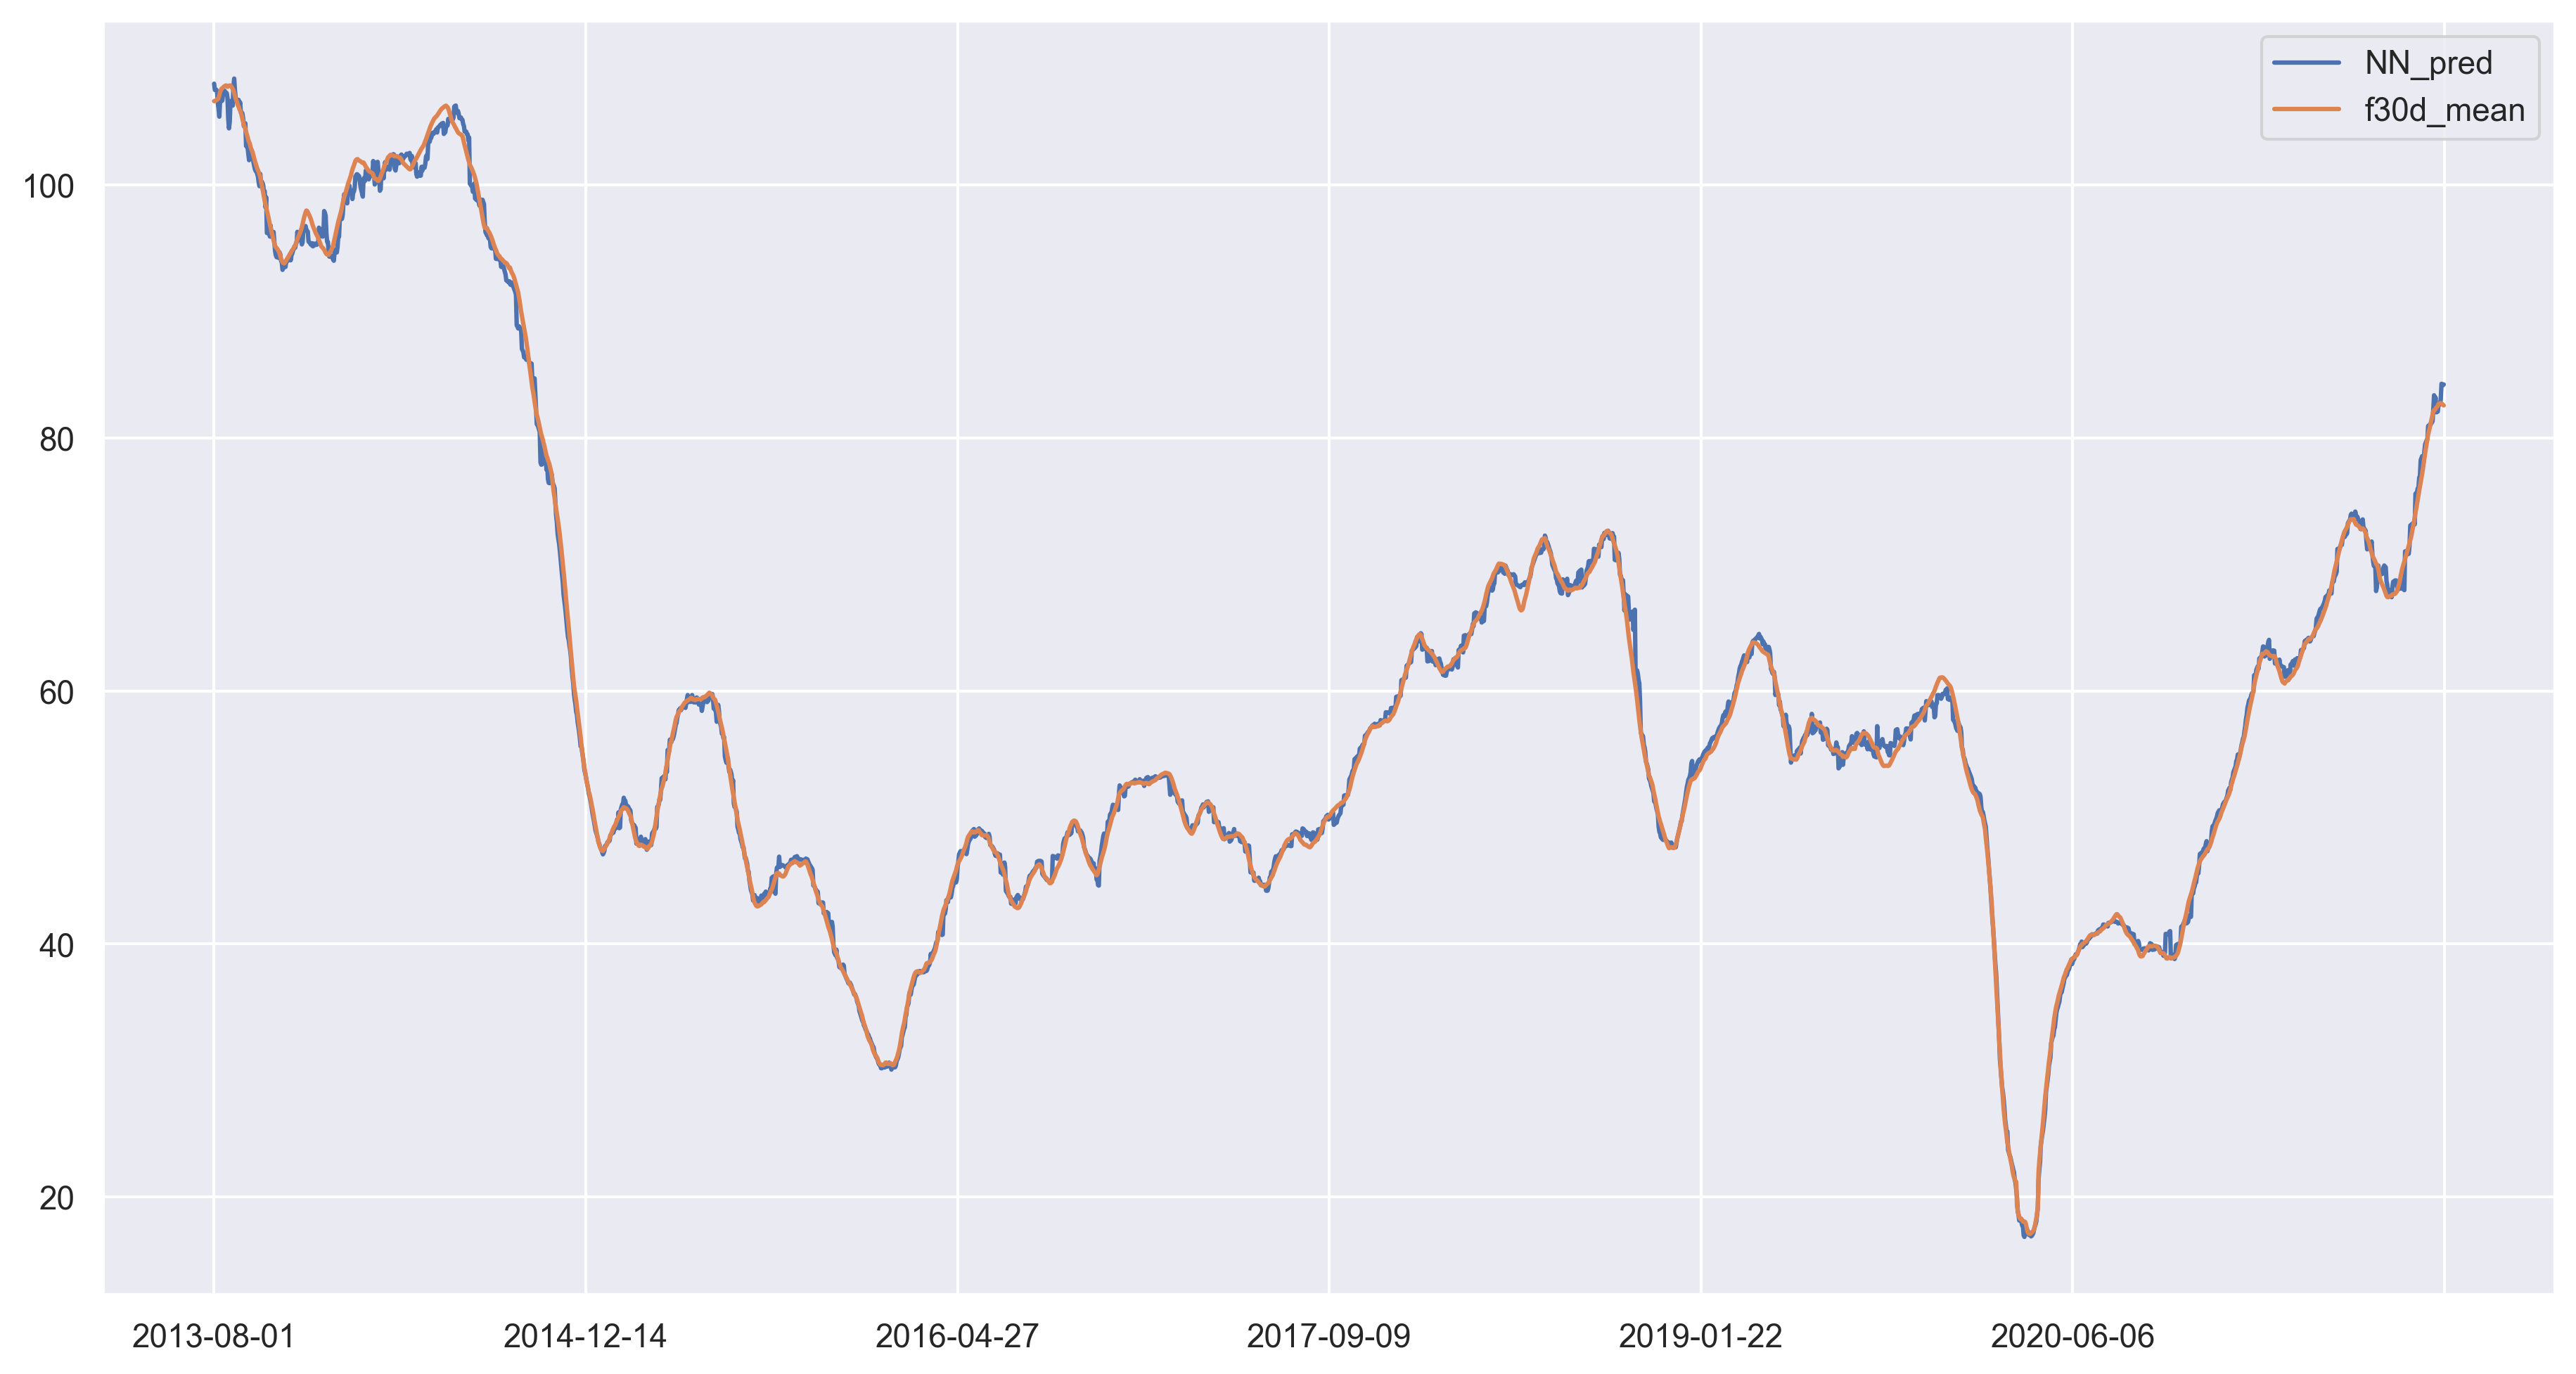

In [15]:
# model fit, most recent data:

mv[-3000:][['NN_pred', 'f30d_mean']].plot(figsize=(15,8))

(0.0, 88.0502851409912)

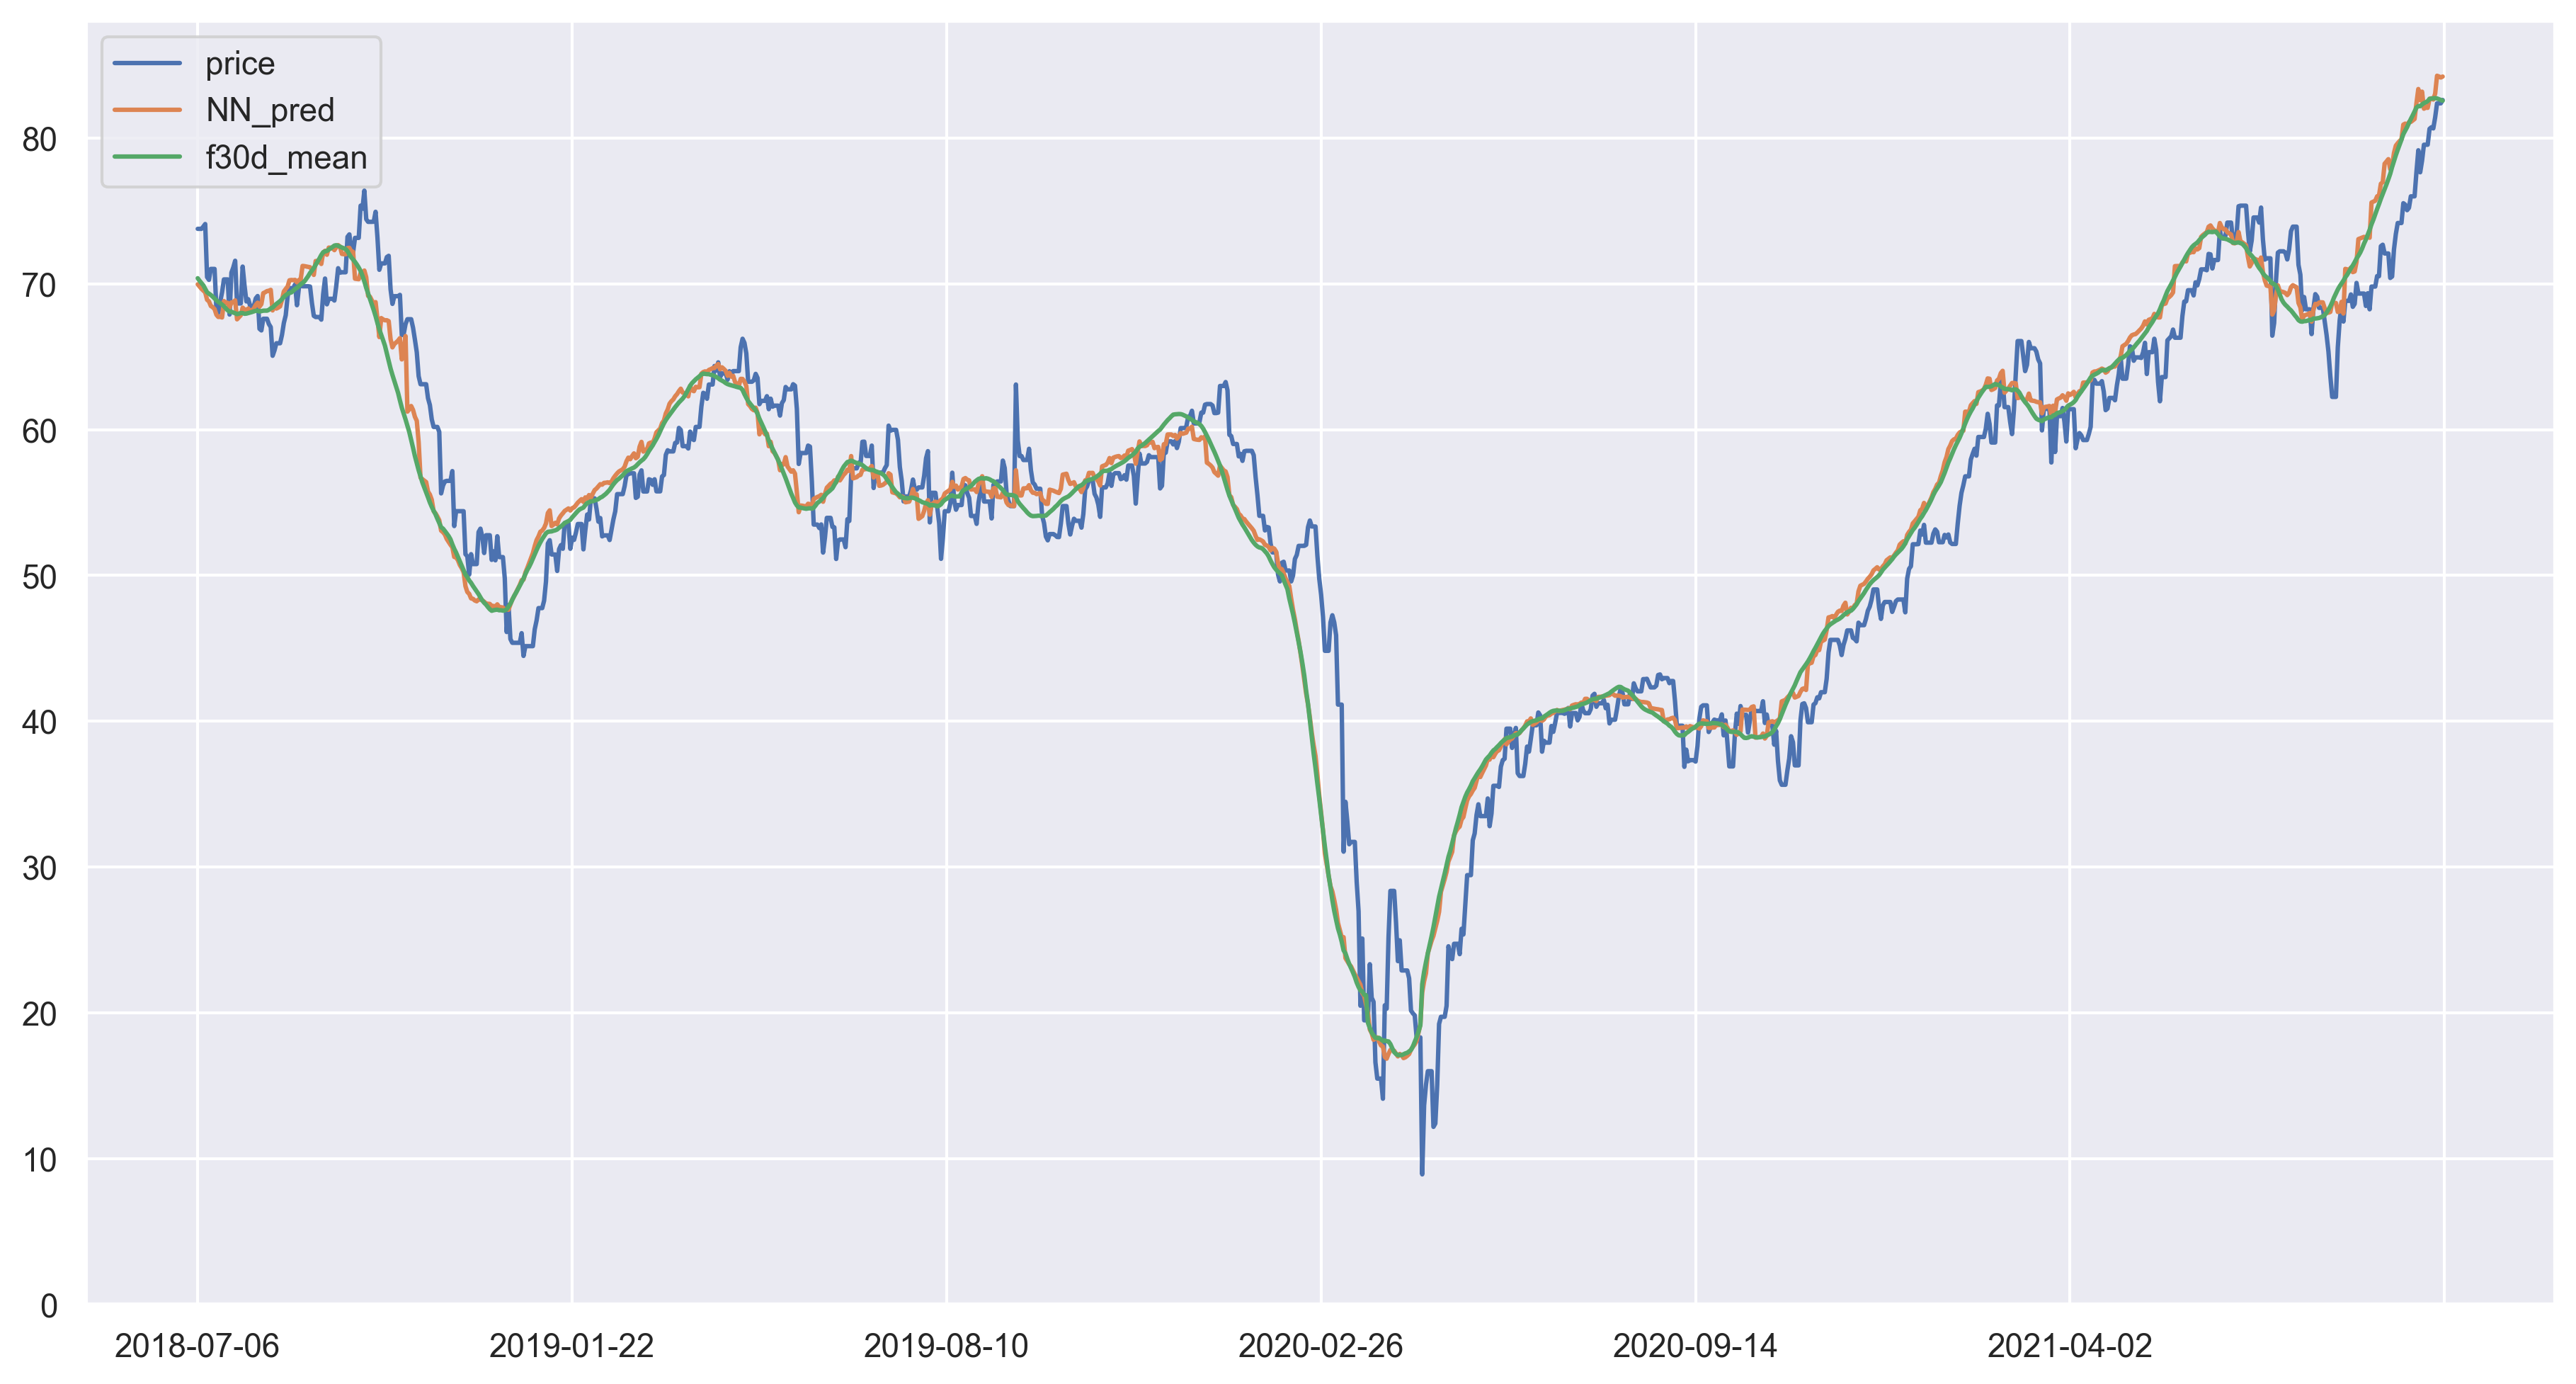

In [16]:
# overall model fit with overlaid visualization of current spot rate:

mv[-1200:][['price', 'NN_pred', 'f30d_mean']].plot()

plt.ylim(0,)

---
The most critical decisions based on oil price would be made in anticipation of large changes in the oil price. Thus, it's desirable to know how model error varies relative to the rapidity of change in the spot rate. I'll check this by plotting the 'price deviation' (forward-30-days average price - spot rate) versus model prediction error. Observed trending in the model error could also be used to infer missing determinants that should be accounted for or added to the model.

---

In [17]:
# construct a dataframe with actual spot price, prediction, and actual forward-30-days mean price: 

test_df = pd.DataFrame(scal.inverse_transform(X_test), columns=X.columns)[['price']]
test_df['prediction'] = predictions
test_df['actual'] = y_test.values

# measure the relevant errors:

test_df['pred_error'] = test_df['prediction'] - test_df['actual']
test_df['price_dev'] = test_df['actual'] - test_df['price']

test_df

price  prediction     actual  pred_error  price_dev
0     72.73   71.632790  71.212333    0.420456  -1.517667
1     58.08   62.474953  63.413000   -0.938047   5.333000
2     99.40   98.376183  98.813000   -0.436817  -0.587000
3     24.79   27.231758  27.979667   -0.747909   3.189667
4     18.70   18.151871  18.701667   -0.549796   0.001667
...     ...         ...        ...         ...        ...
3479  48.34   50.083183  49.547667    0.535517   1.207667
3480  44.08   49.151833  50.134333   -0.982501   6.054333
3481  48.41   50.525974  51.819667   -1.293692   3.409667
3482  51.46   49.261925  50.064333   -0.802409  -1.395667
3483  20.57   25.509676  27.135667   -1.625991   6.565667

[3484 rows x 5 columns]

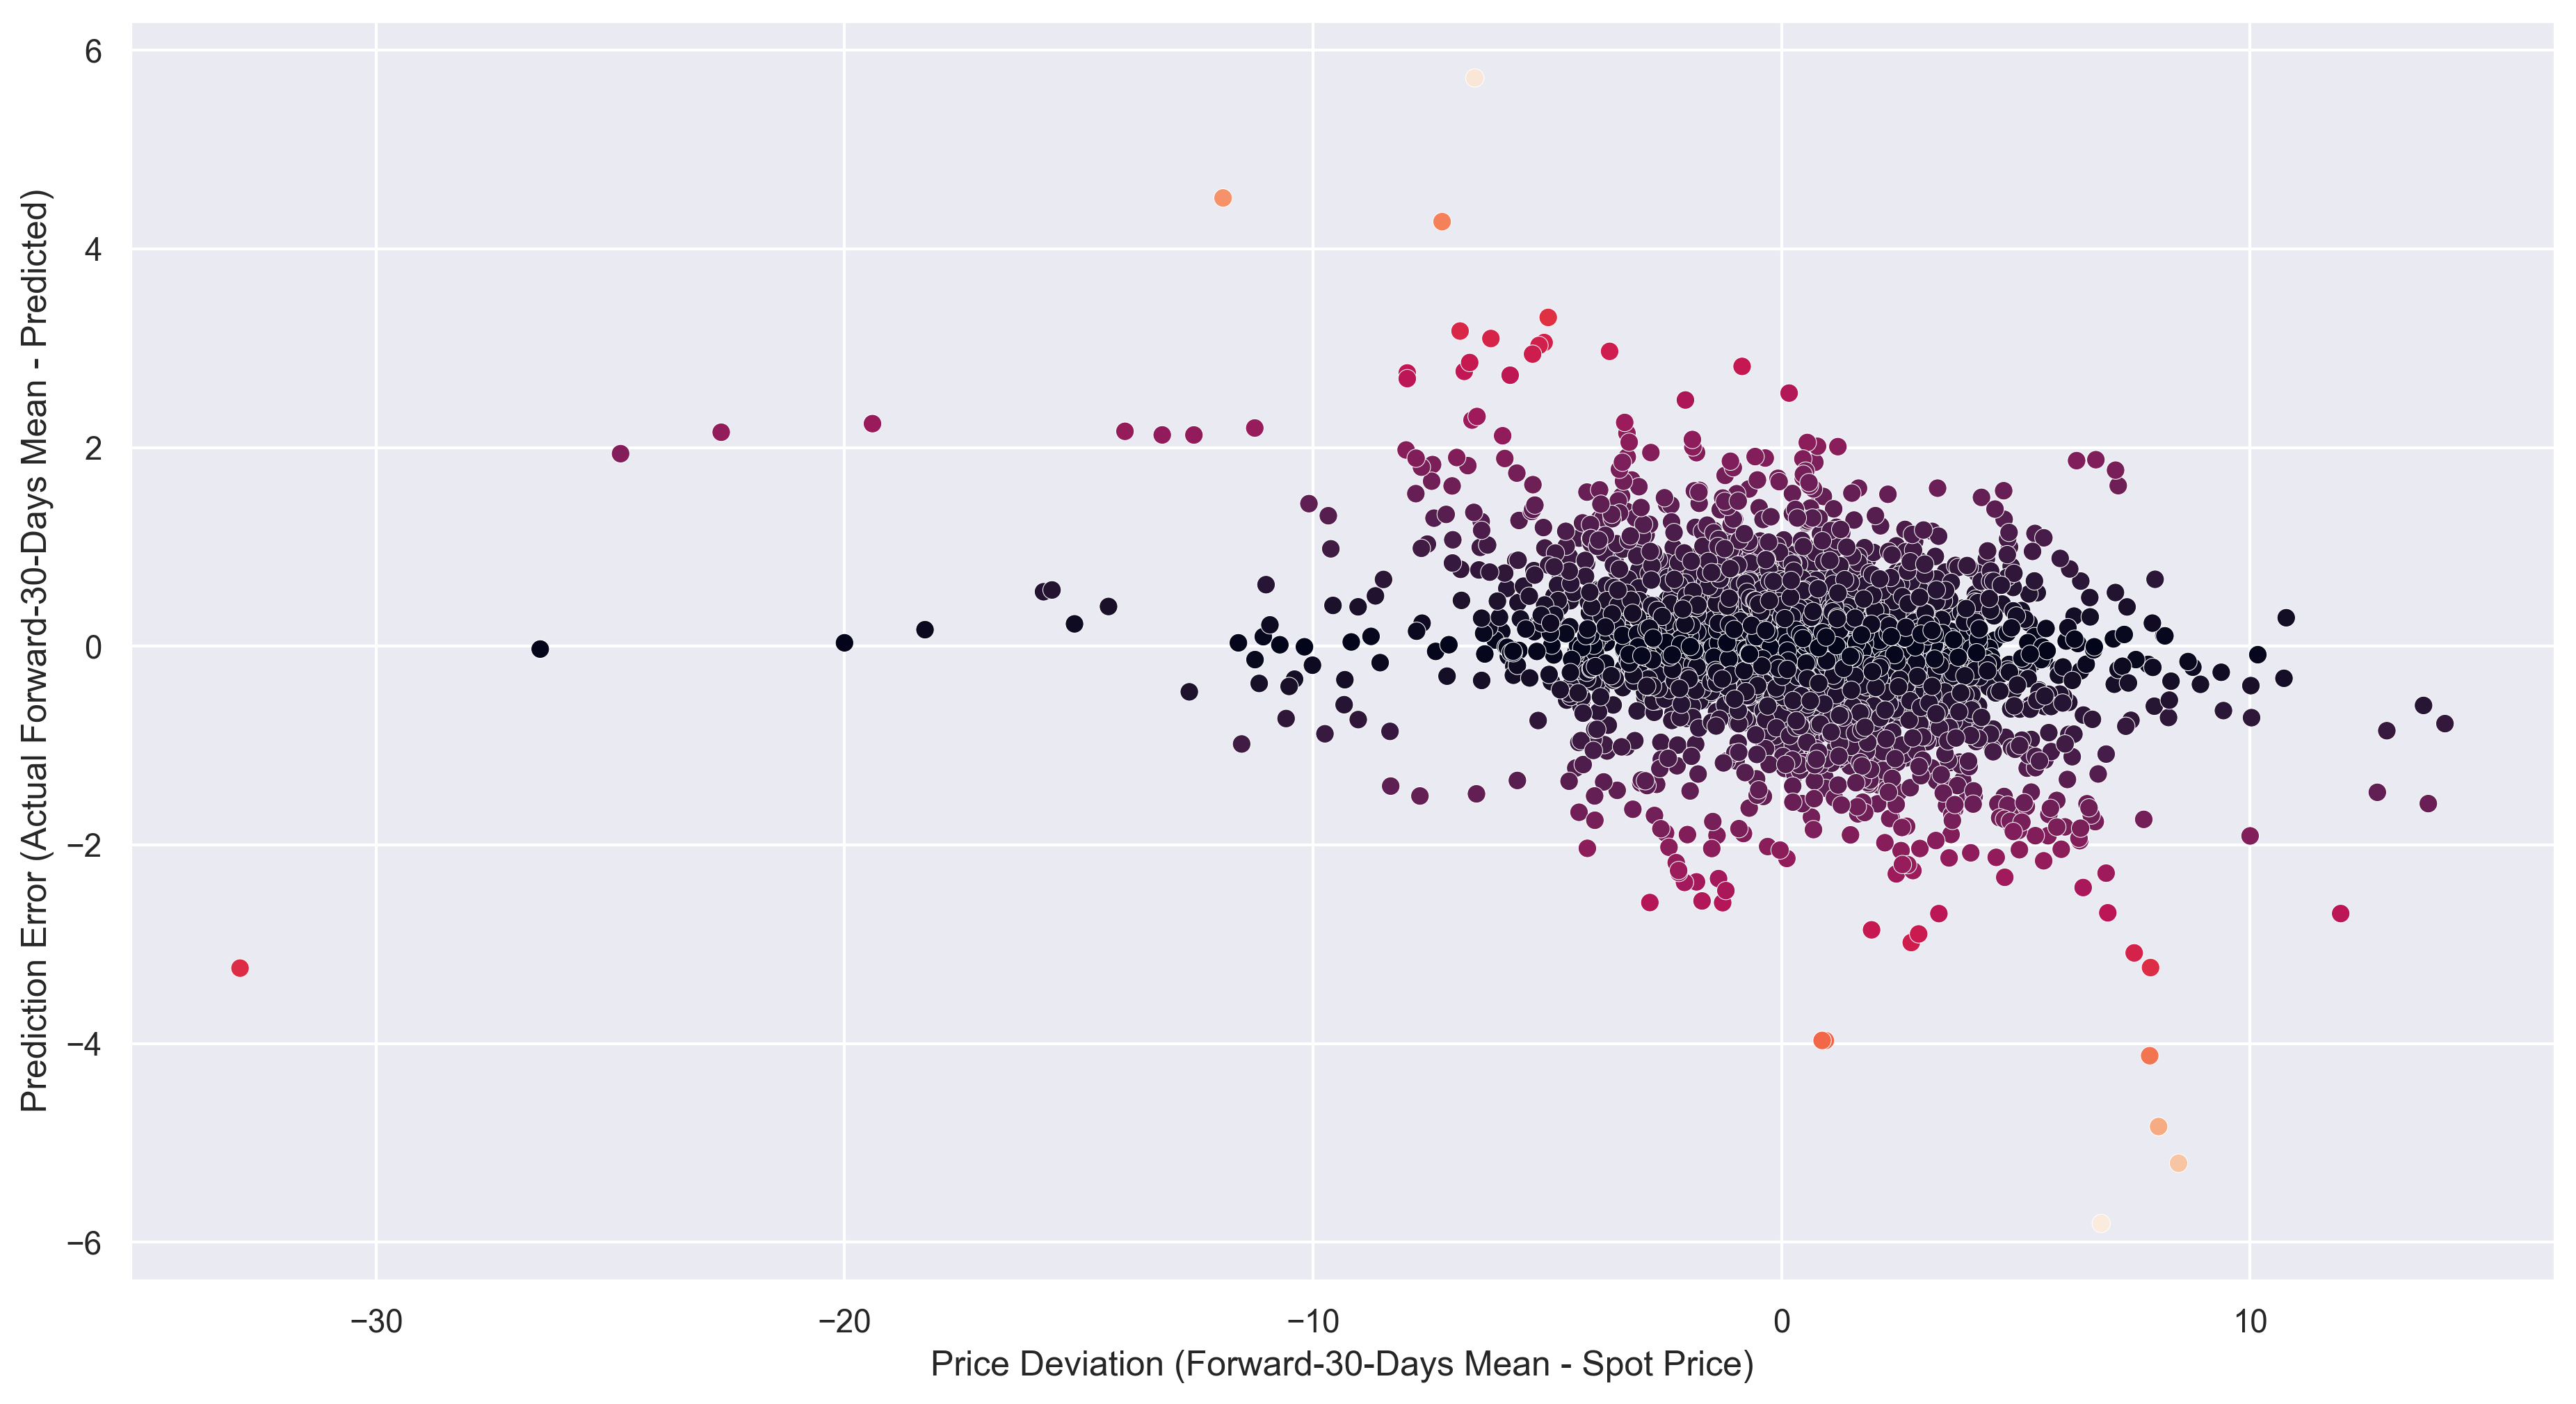

In [18]:
# view the residual trend relative to price deviation:

plt.scatter(test_df['price_dev'], test_df['pred_error'], 
            linewidth=0.25, 
            edgecolors='white',
            s=40,
            c=abs(test_df['pred_error']))

plt.xlabel('Price Deviation (Forward-30-Days Mean - Spot Price)')
plt.ylabel('Prediction Error (Actual Forward-30-Days Mean - Predicted)');

---------------------------------------------------

#### B) Comparison to Baseline

It's common to base economic analysis on the presumption, for lack of better information, that ongoing oil prices remain flat. The model should improve upon this baseline as a minimum. 

I'm considering two alternative baselines which may add to or replace the current (daily spot rate) baseline:
<ul>
    <li>30-days average spot price (similar to daily but more stable)
    <li>Trailing 12-months average spot price (basis for SEC booked reserves economics)
</ul>
...stay tuned for that later addition.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='price', ylabel='f30d_mean'>

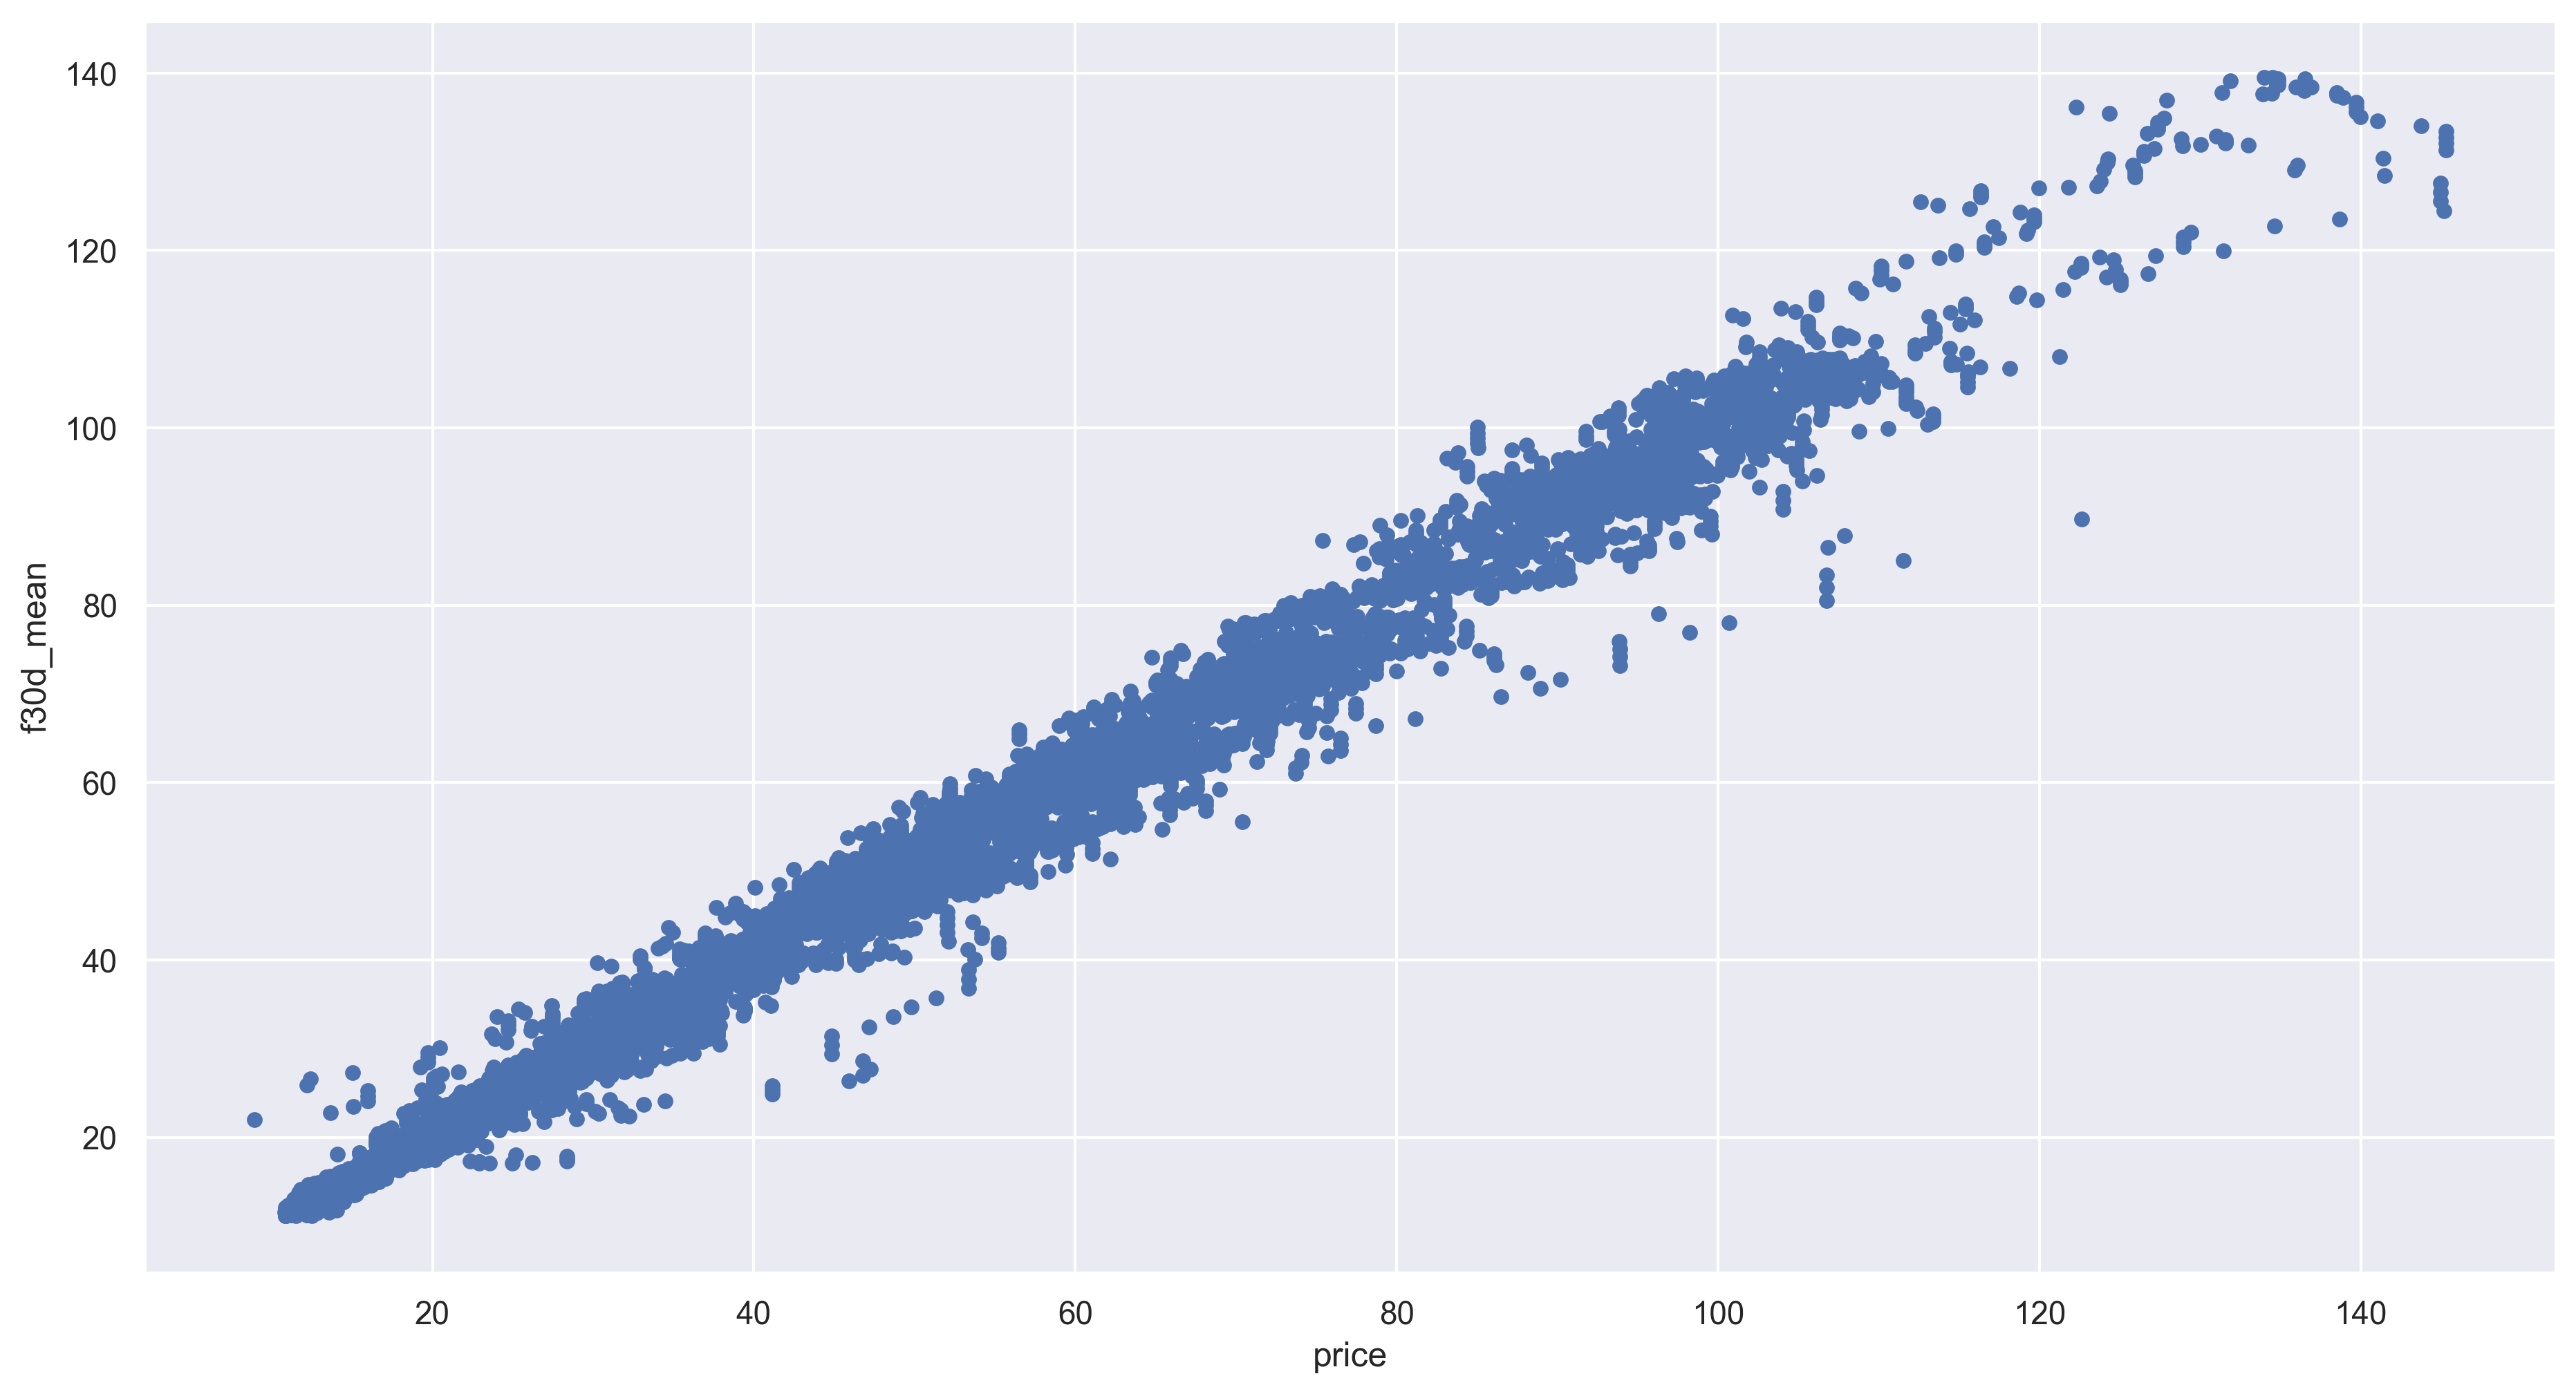

In [19]:
# a visualization of current spot rate (x-axis) versus forward-30-day mean (y-axis):

mv.plot.scatter(x='price', y='f30d_mean')

In [20]:
# quick view of model results
# mse & mae based on test data & predictions:

model_mse, model_mae = mse(y_test, predictions), mae(y_test, predictions)
model_mse, model_mae

(0.5696606243379909, 0.5201947444064654)

In [21]:
# comparison view of "assumed flat oil price"
# mse & mae based on test data vs. same-date spot price

X_test_price = pd.DataFrame(scal.inverse_transform(X_test))[0]

base_mse, base_mae = mse(y_test, X_test_price), mae(y_test, X_test_price)
base_mse, base_mae

(9.283846522483735, 2.0102813815537695)

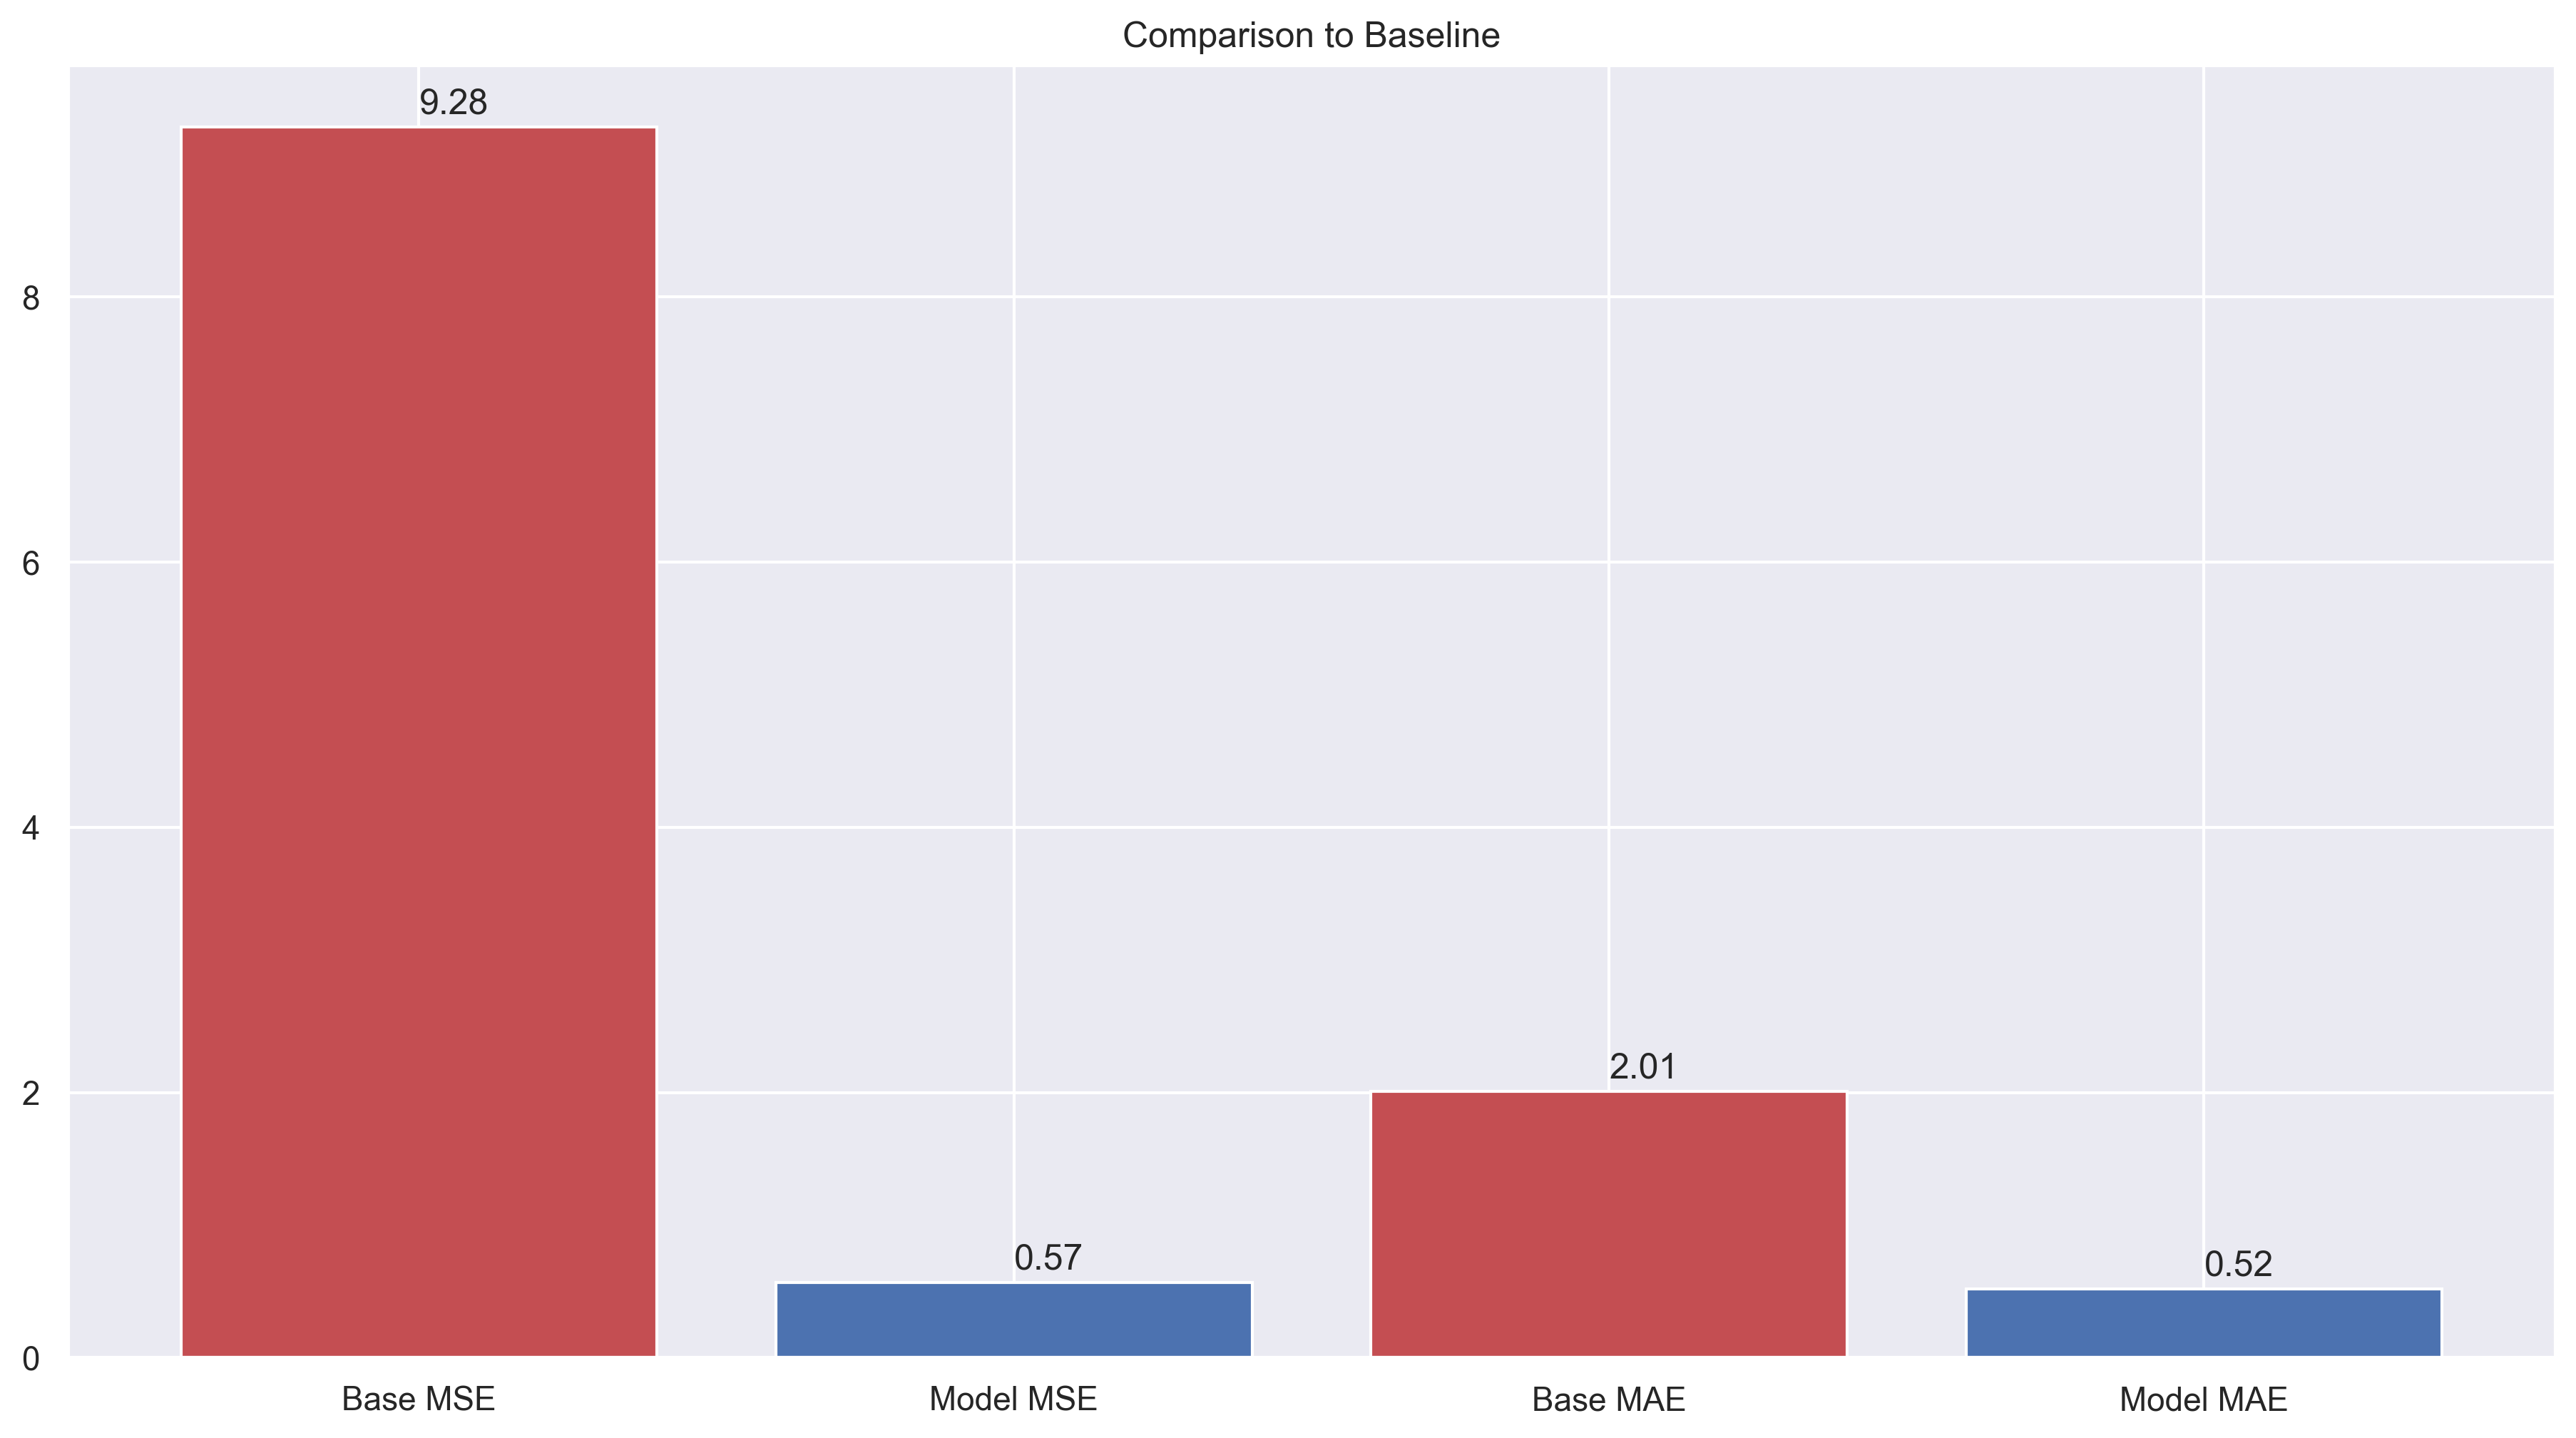

In [22]:
# visualize comparison of model vs. baseline error: 

xs = ['Base MSE', 'Model MSE', 'Base MAE', 'Model MAE']
ys = [base_mse, model_mse, base_mae, model_mae]

plt.bar(xs, ys, color=['r', 'b', 'r', 'b']);

plt.title('Comparison to Baseline')

for i in range(len(xs)):
    plt.text(xs[i], ys[i] + 0.1, '{:.2f}'.format(ys[i]))

#### The model shows significant improvement over baseline.
---

---
### 5) Model Explanation Using SHAP
---

Python SHAP is an extremely cool package! What I'm showing here are just some of the basics.

Notes on each feature (refer to the cross-plots or "dependence plots" a few cells below):
- <strong>Forward 30-Day GDP:</strong> Very intuitive positive correlation to forward 30-day WTI price. The detected interaction with storage suggests that when storage volumes are high (surplus WTI) the effect of GDP on increasing WTI price is curtailed. 
- <strong>GDP:</strong> Another positive correlation to WTI price that makes sense, and we see the interaction with storage persist. 
- <strong>US Production:</strong> This one also makes sense. Market oversupply should drive lower WTI prices. The interaction with forward 365-day GDP looks fairly weak.
- <strong>Forward 365-day GDP:</strong> This one is counterintuitive. A forecast for increasing GDP over the coming year should drive higher WTI prices, but the opposite seems apparent in the model. The interaction with trailing 90-day WTI price may be the key, but I'm not sure what to make of it. Further study warranted.
- <strong>Trailing 30-day WTI Price:</strong> Looks reasonable. The model may be acting descriptively here. Again interaction with storage.
- <strong>Storage:</strong> Seems to show an intuitive trend, with an exception where trailing 90-day WTI price is highest and storage volumes are moderate.
- <strong>Trailing 90-Day WTI Price & Current WTI Price:</strong> These show fairly intuitive trends, though with notable scatter, that probably suggest a descriptive relationship between the current or recent price and the forward 30-day price.

In [23]:
# pick the first 1000 lines of the (already randomized) X_test dataframe for the explainer:
X_test_shap = pd.DataFrame(X_test, columns=X.columns)[:1000]

X_kmeans = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(mod.predict, X_kmeans)

shap_values = explainer.shap_values(X_test_shap, nsamples=100)

  0%|          | 0/1000 [00:00<?, ?it/s]

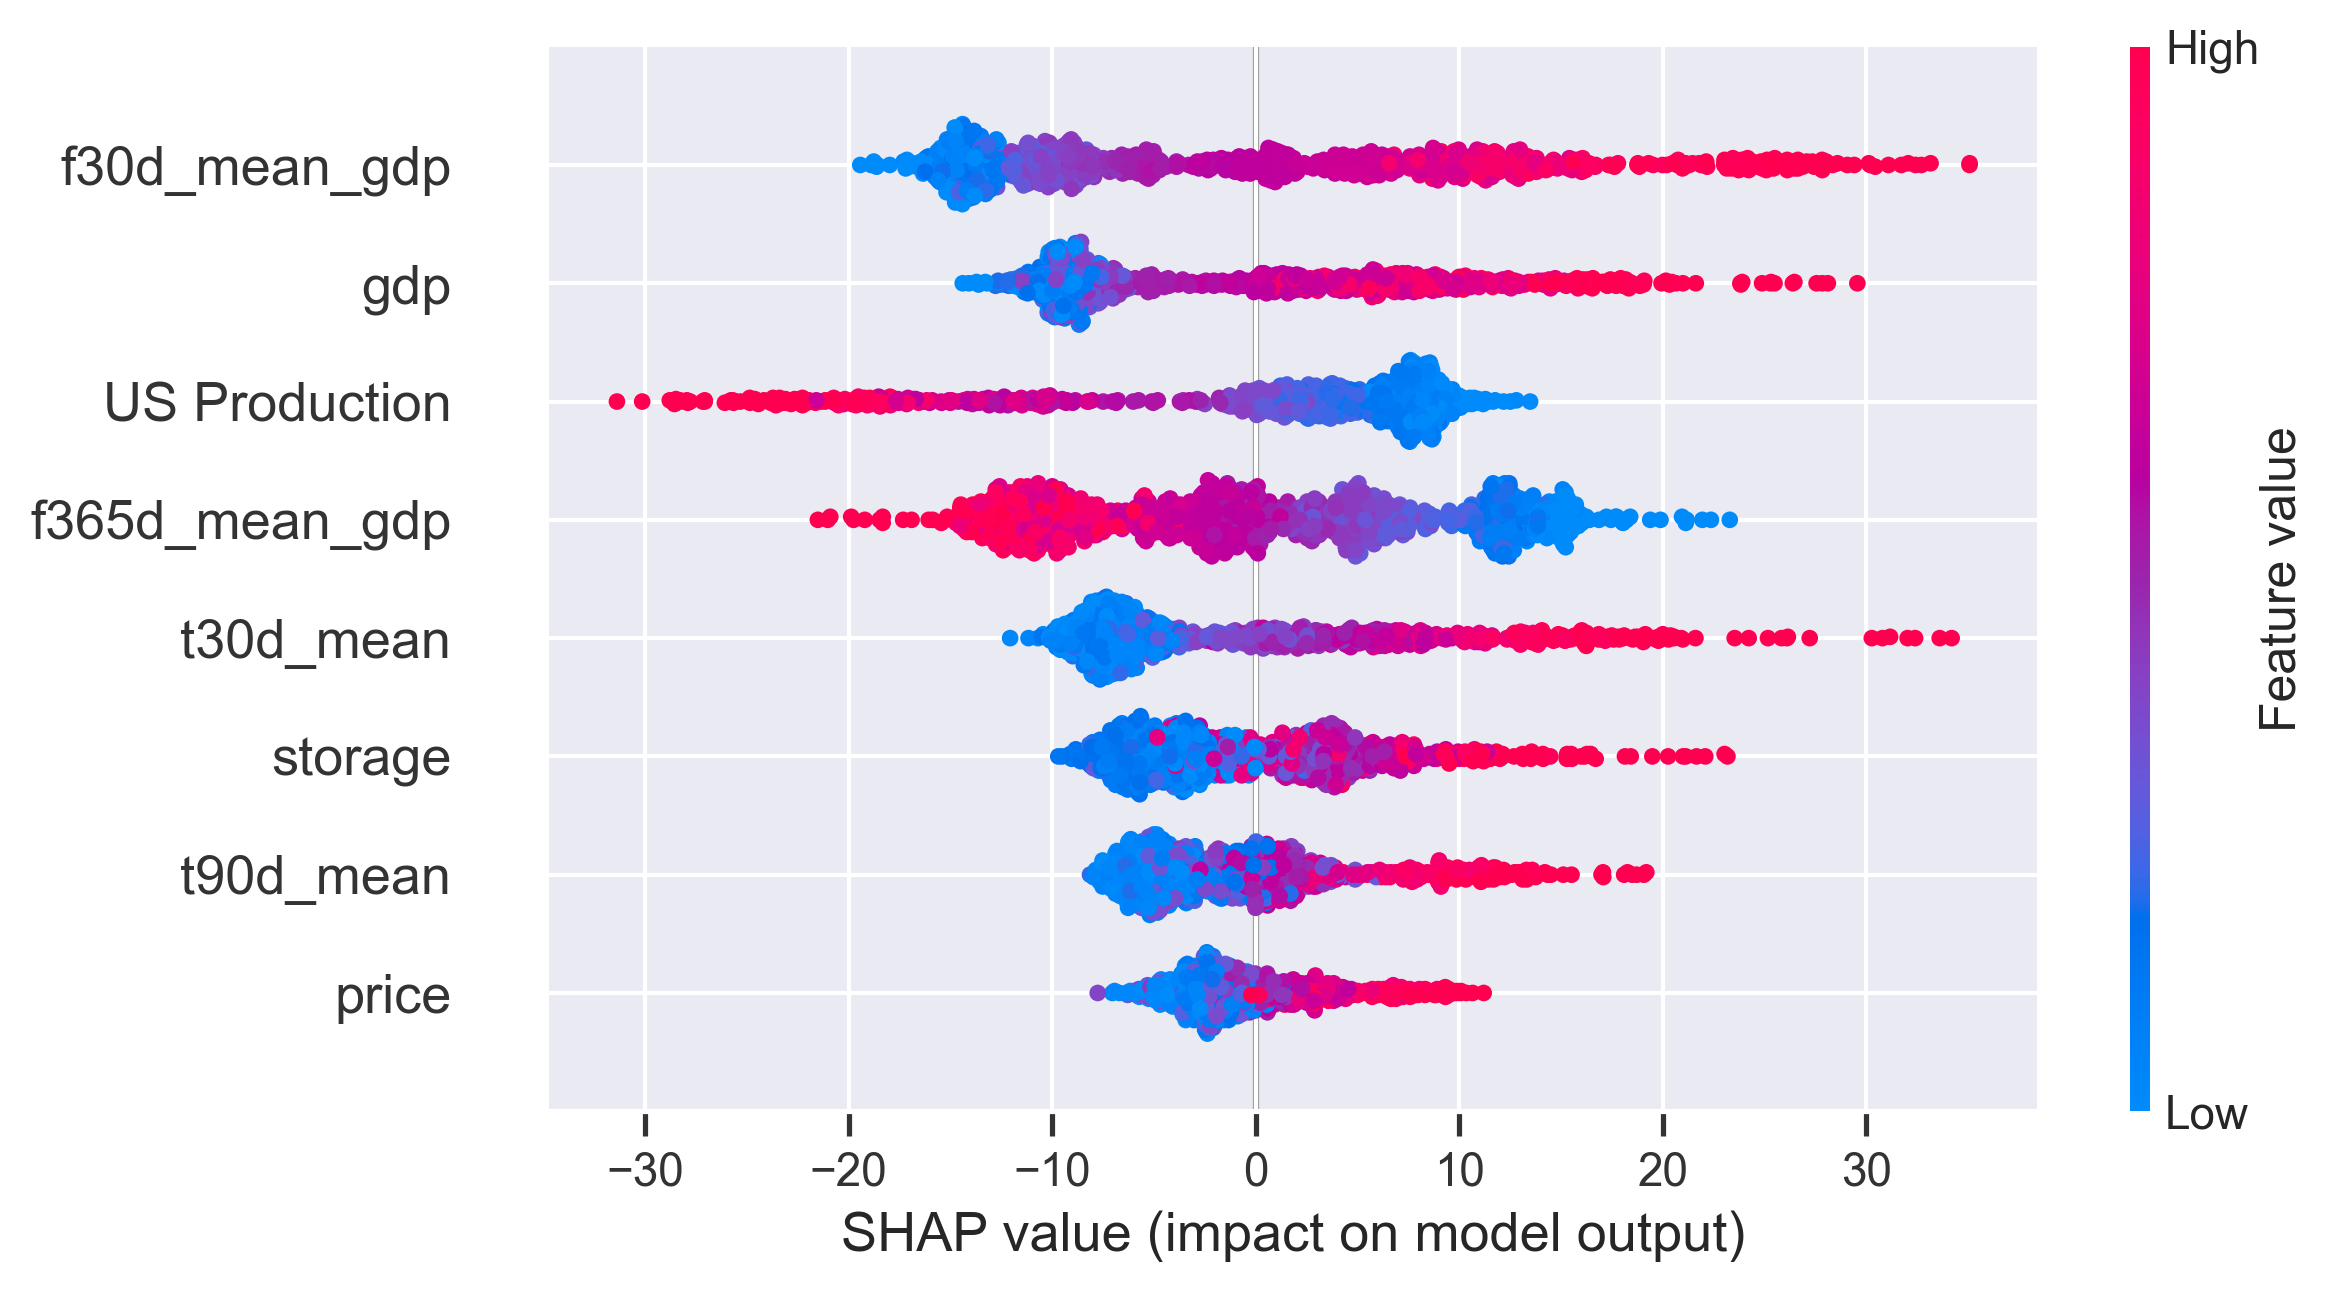

In [24]:
shap.summary_plot(shap_values[0], X_test_shap)

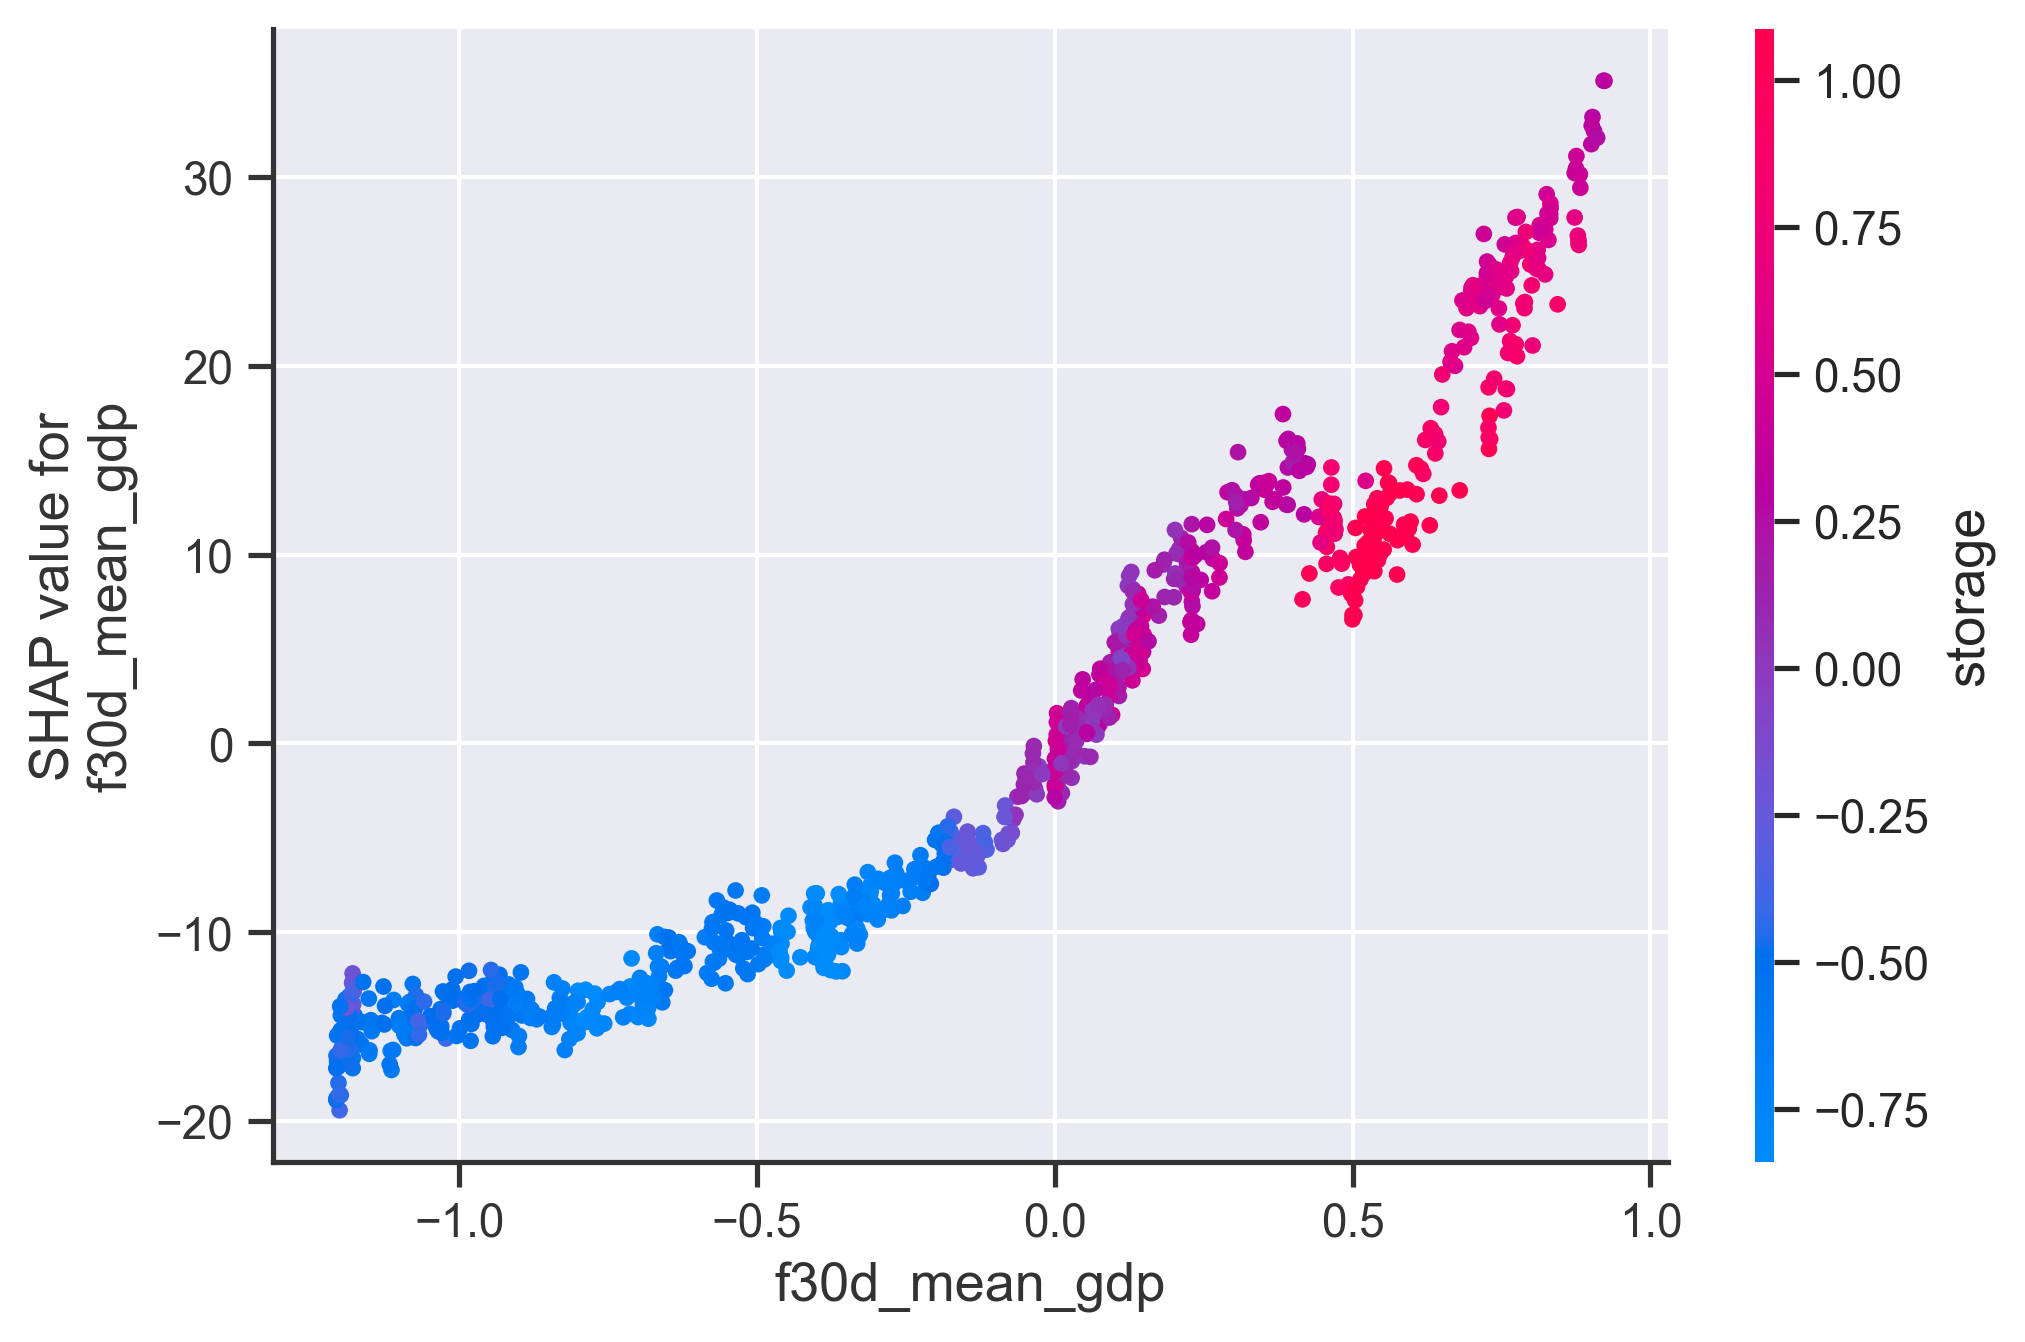

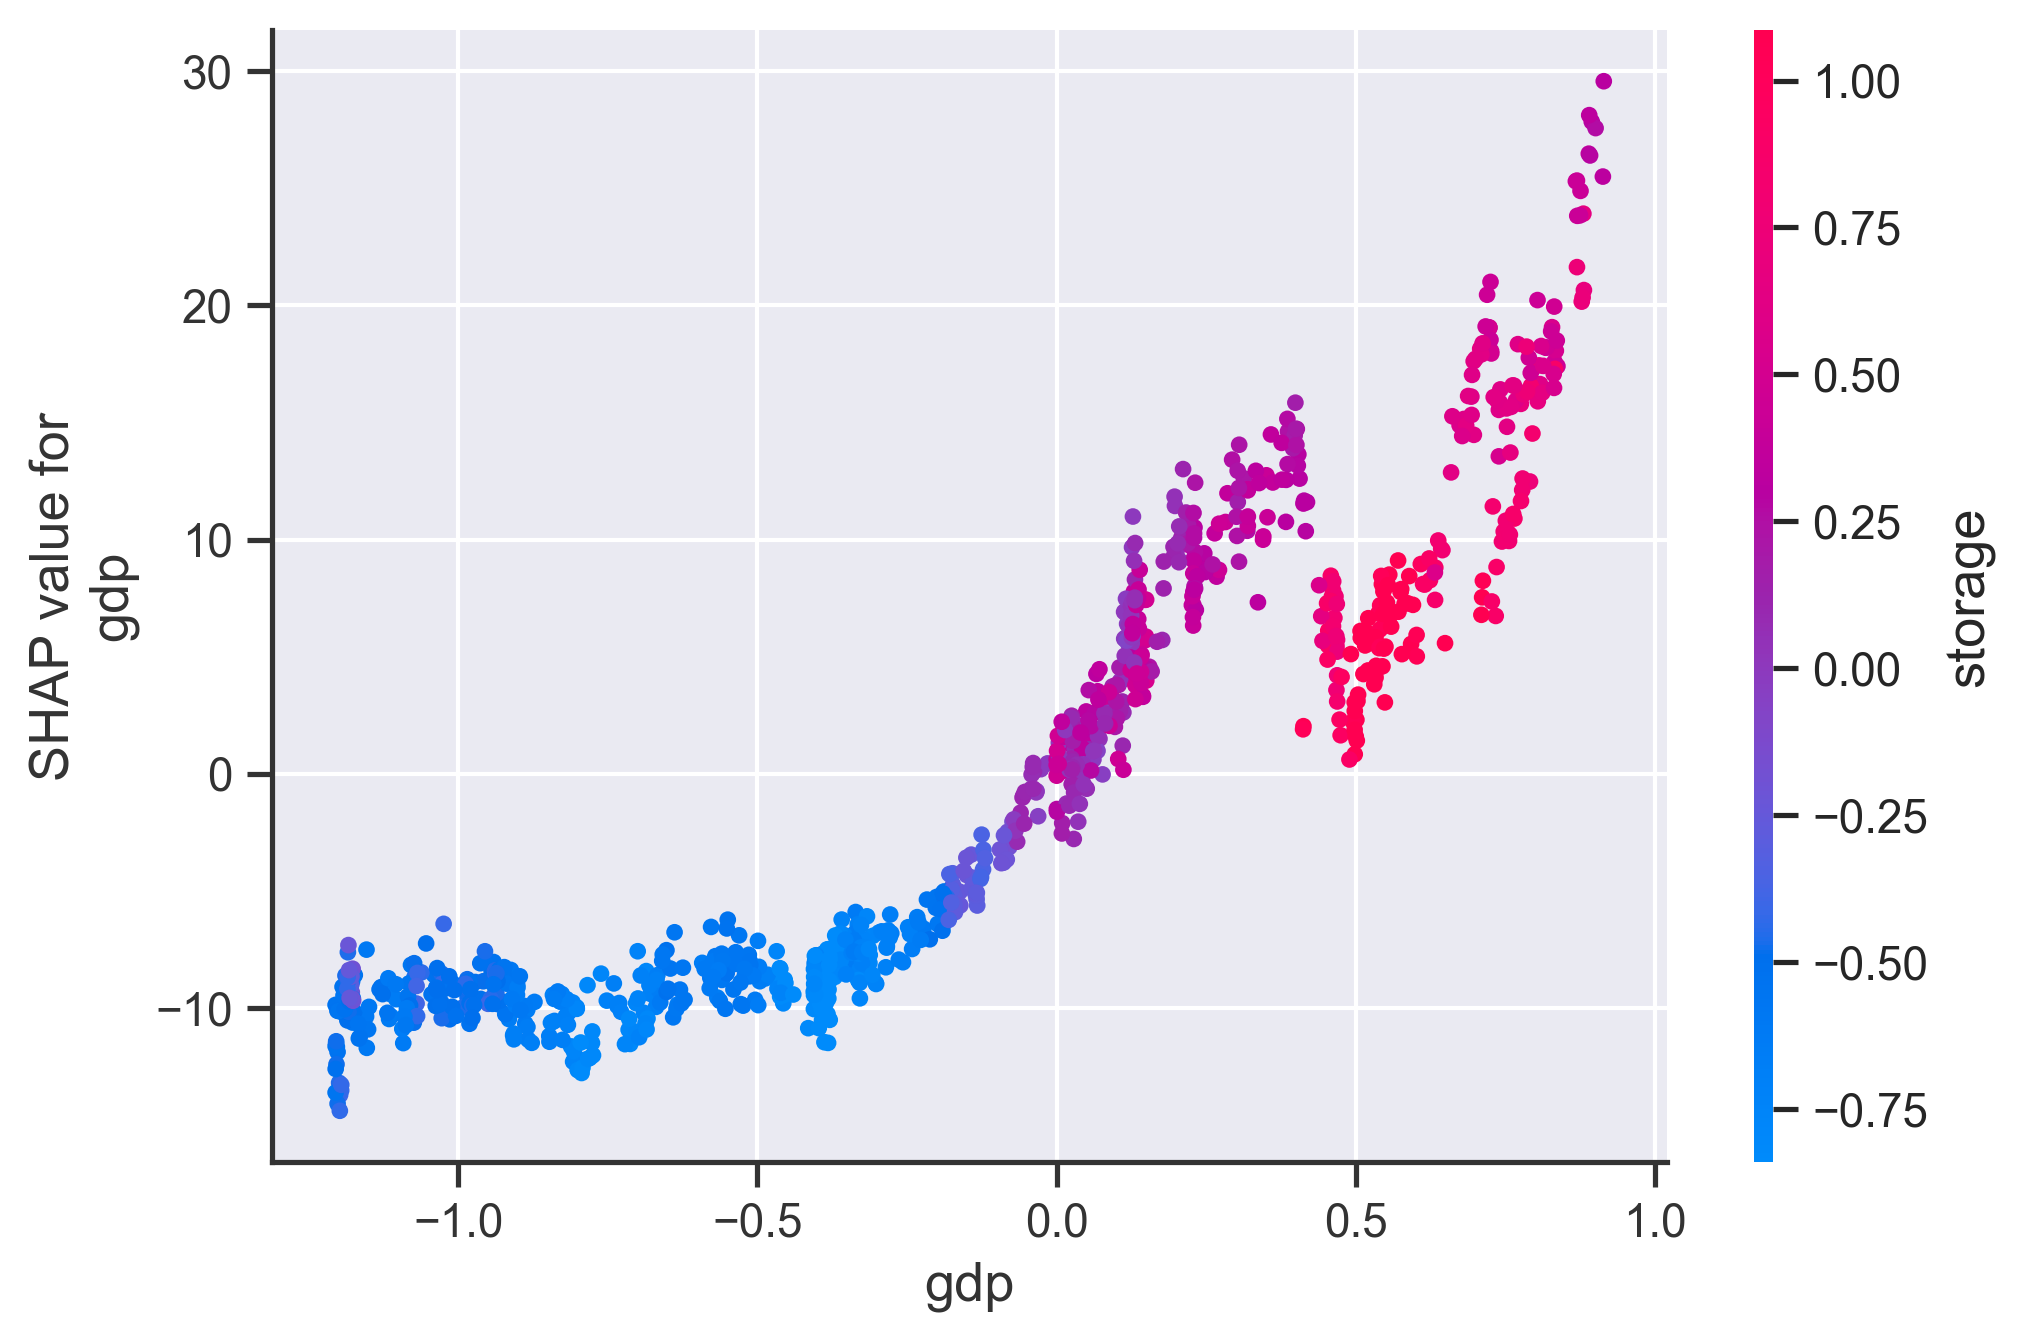

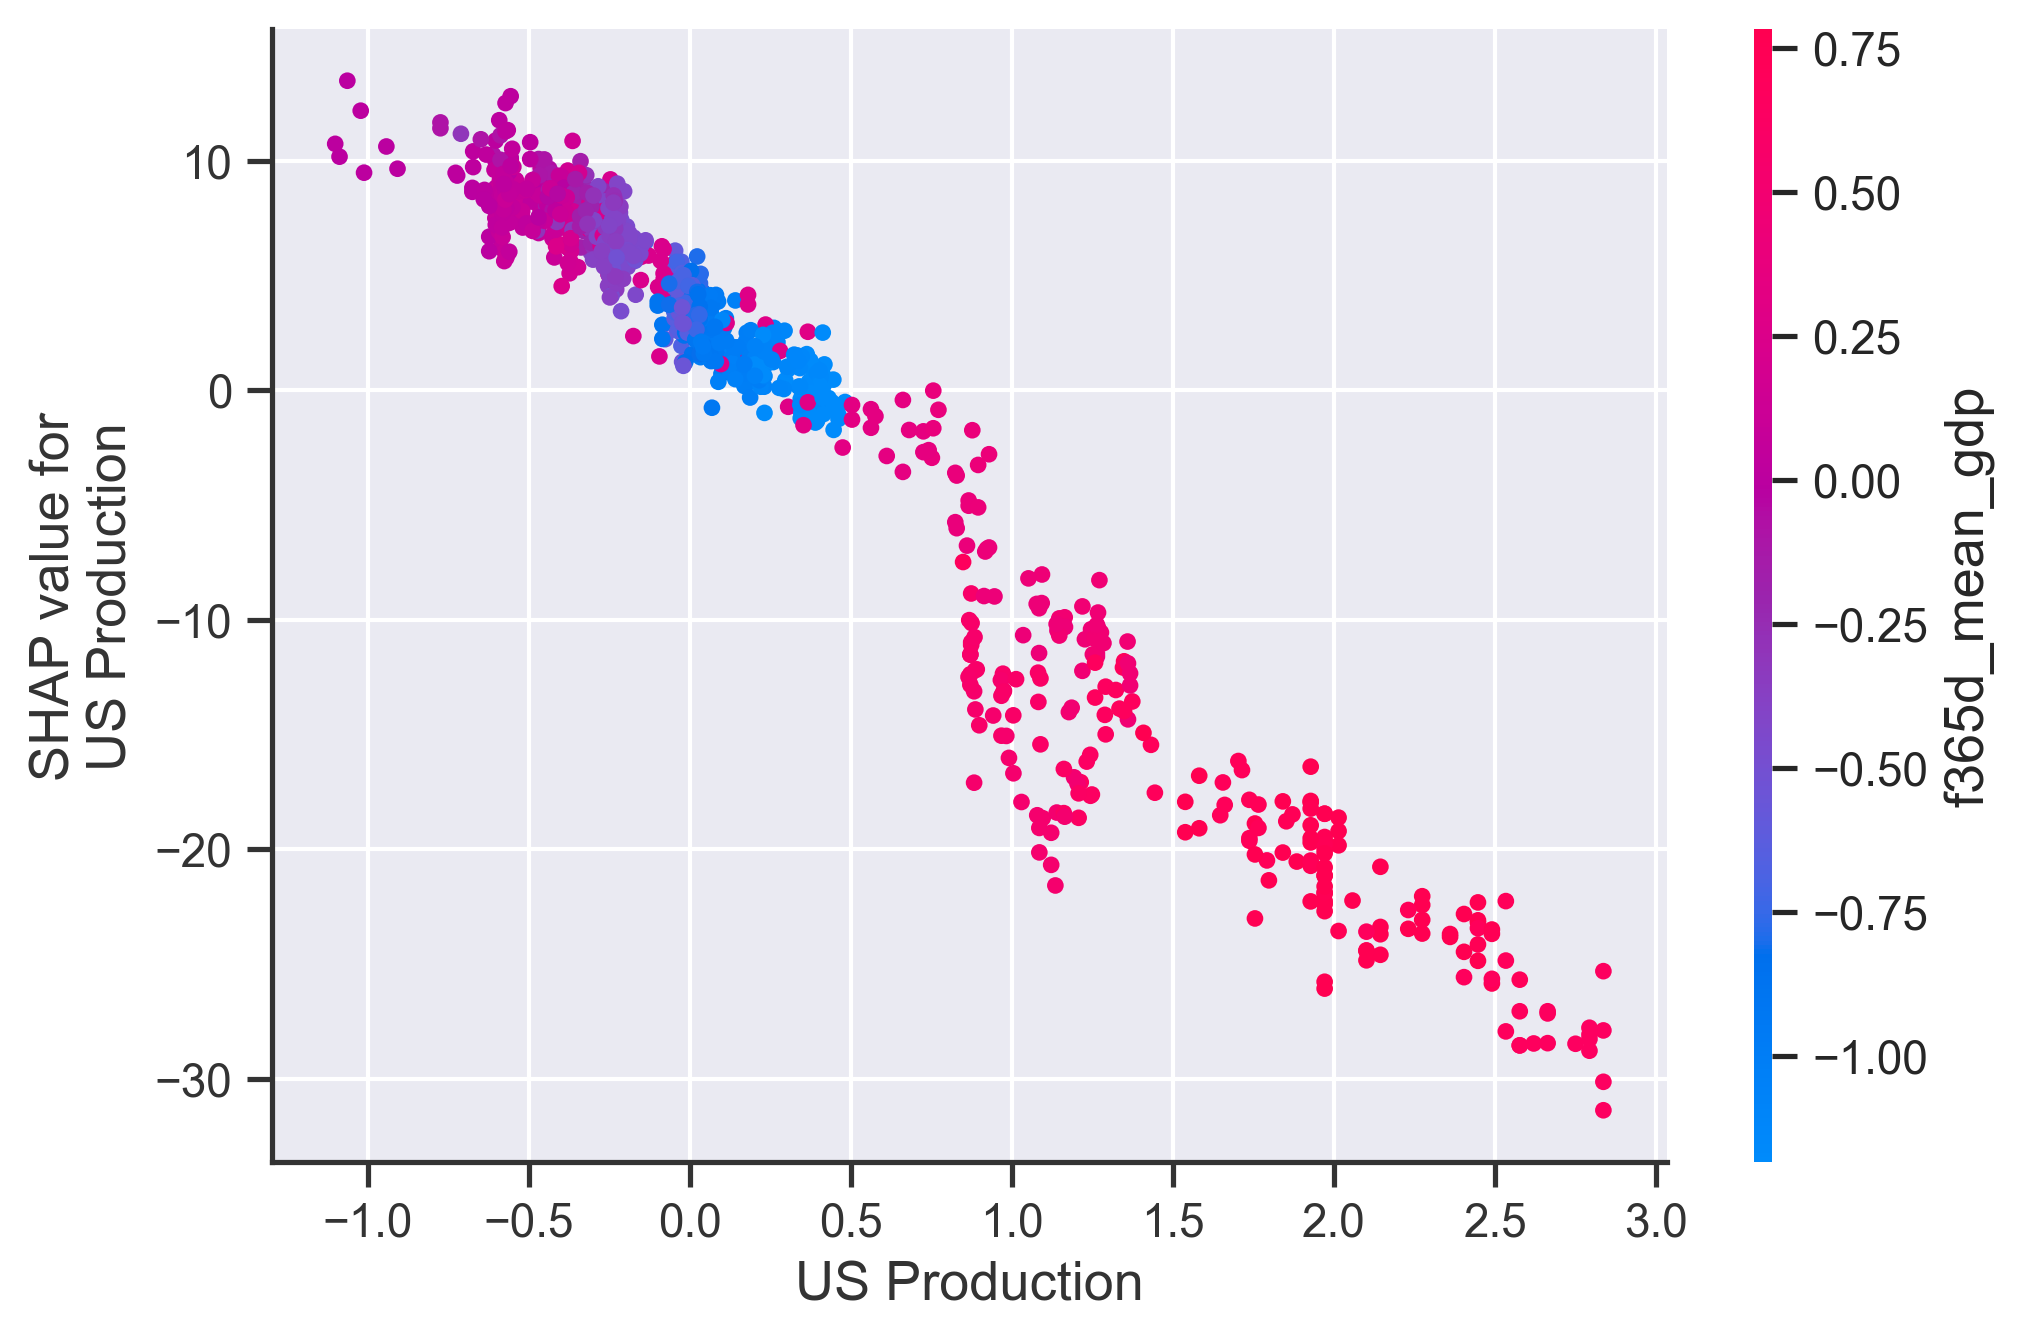

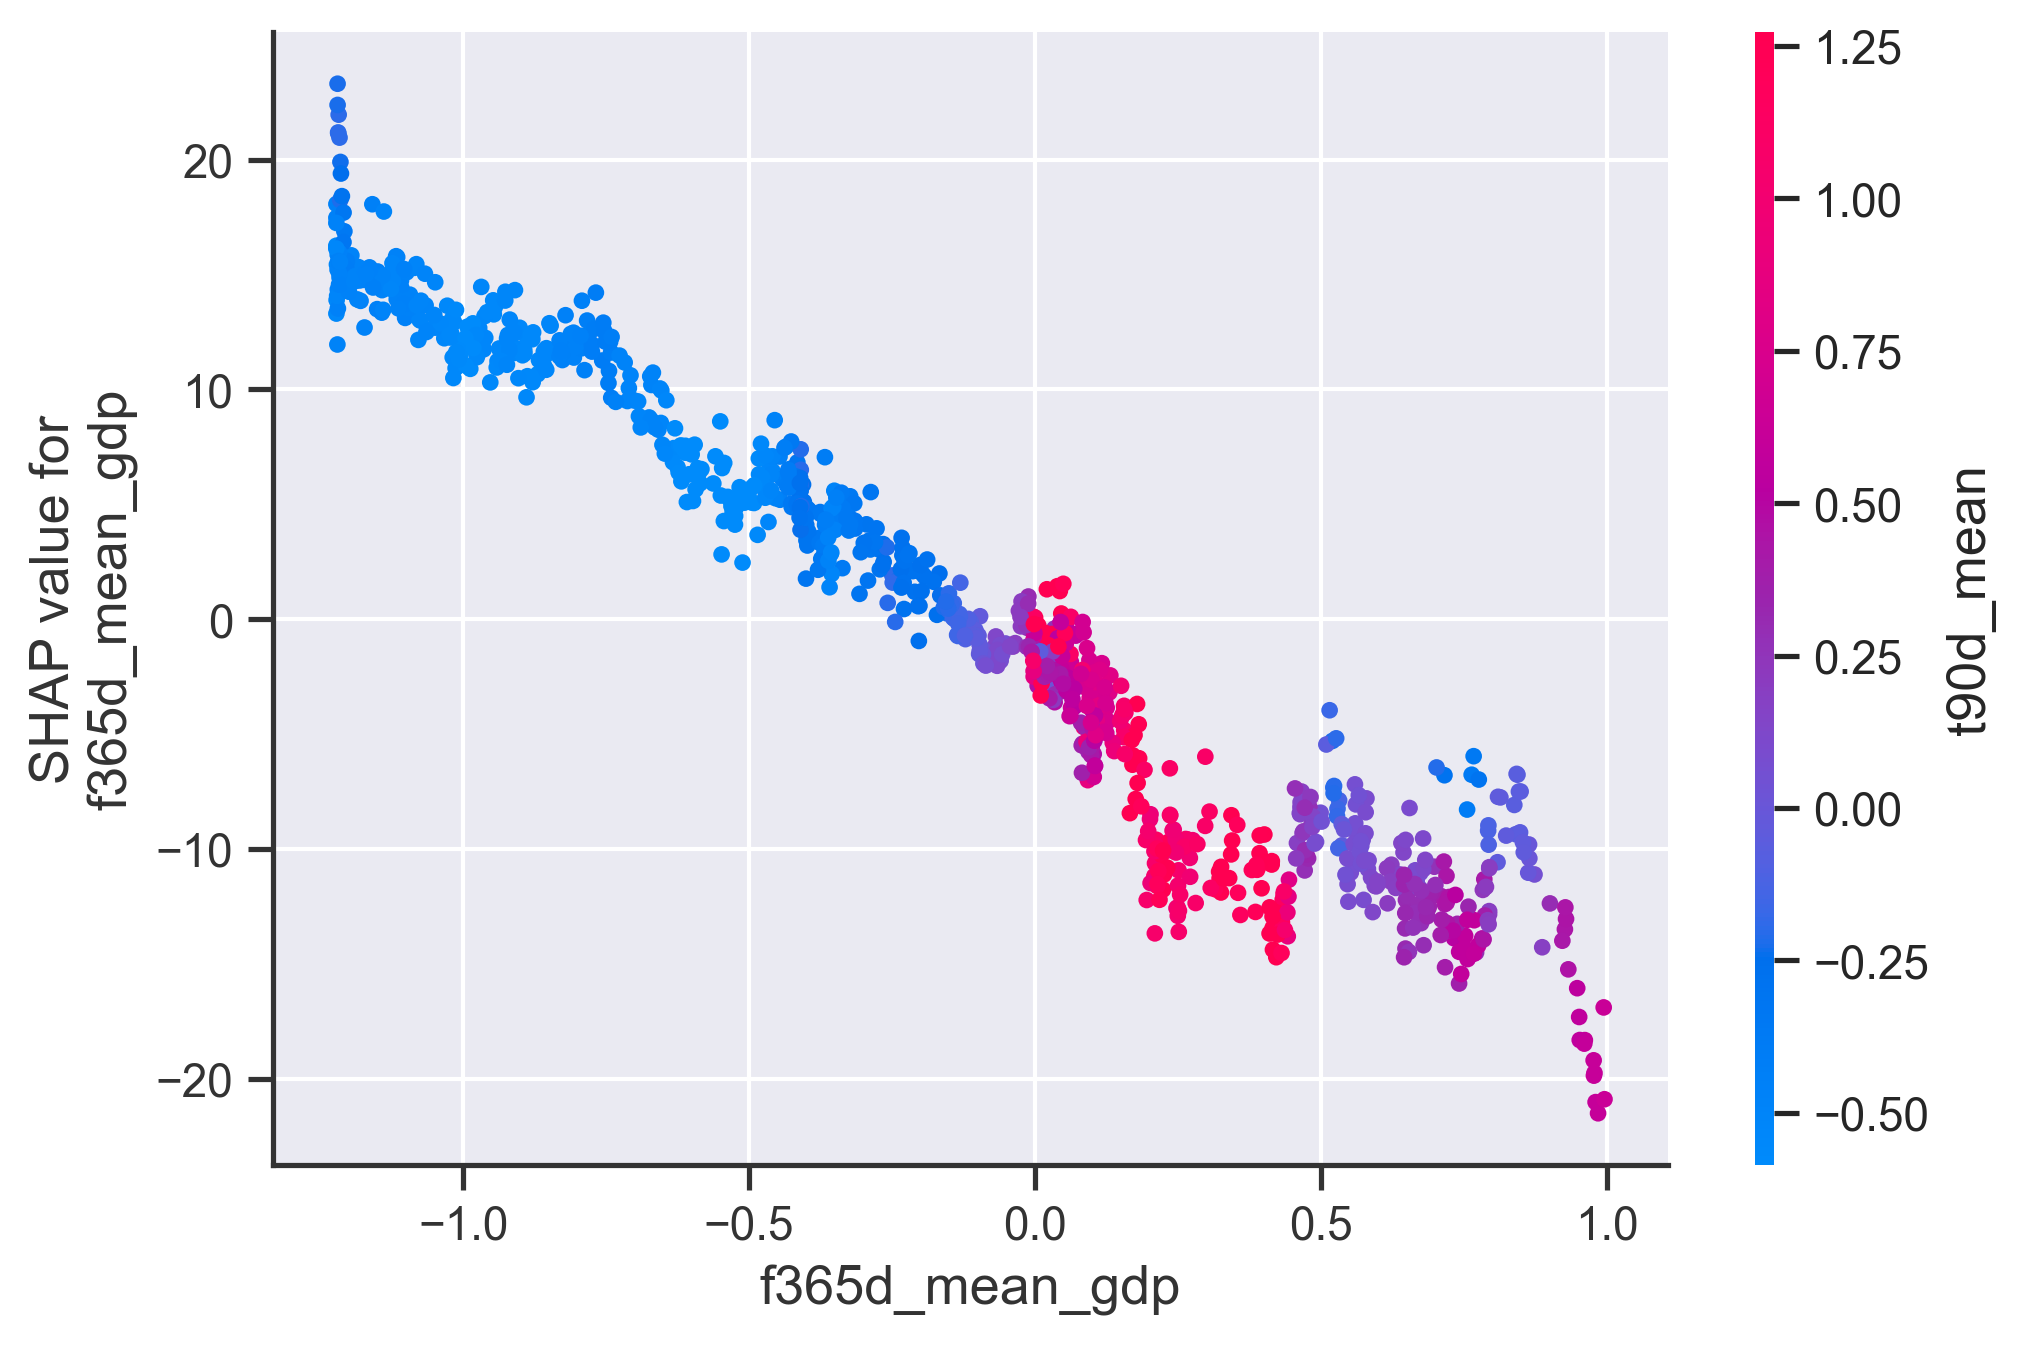

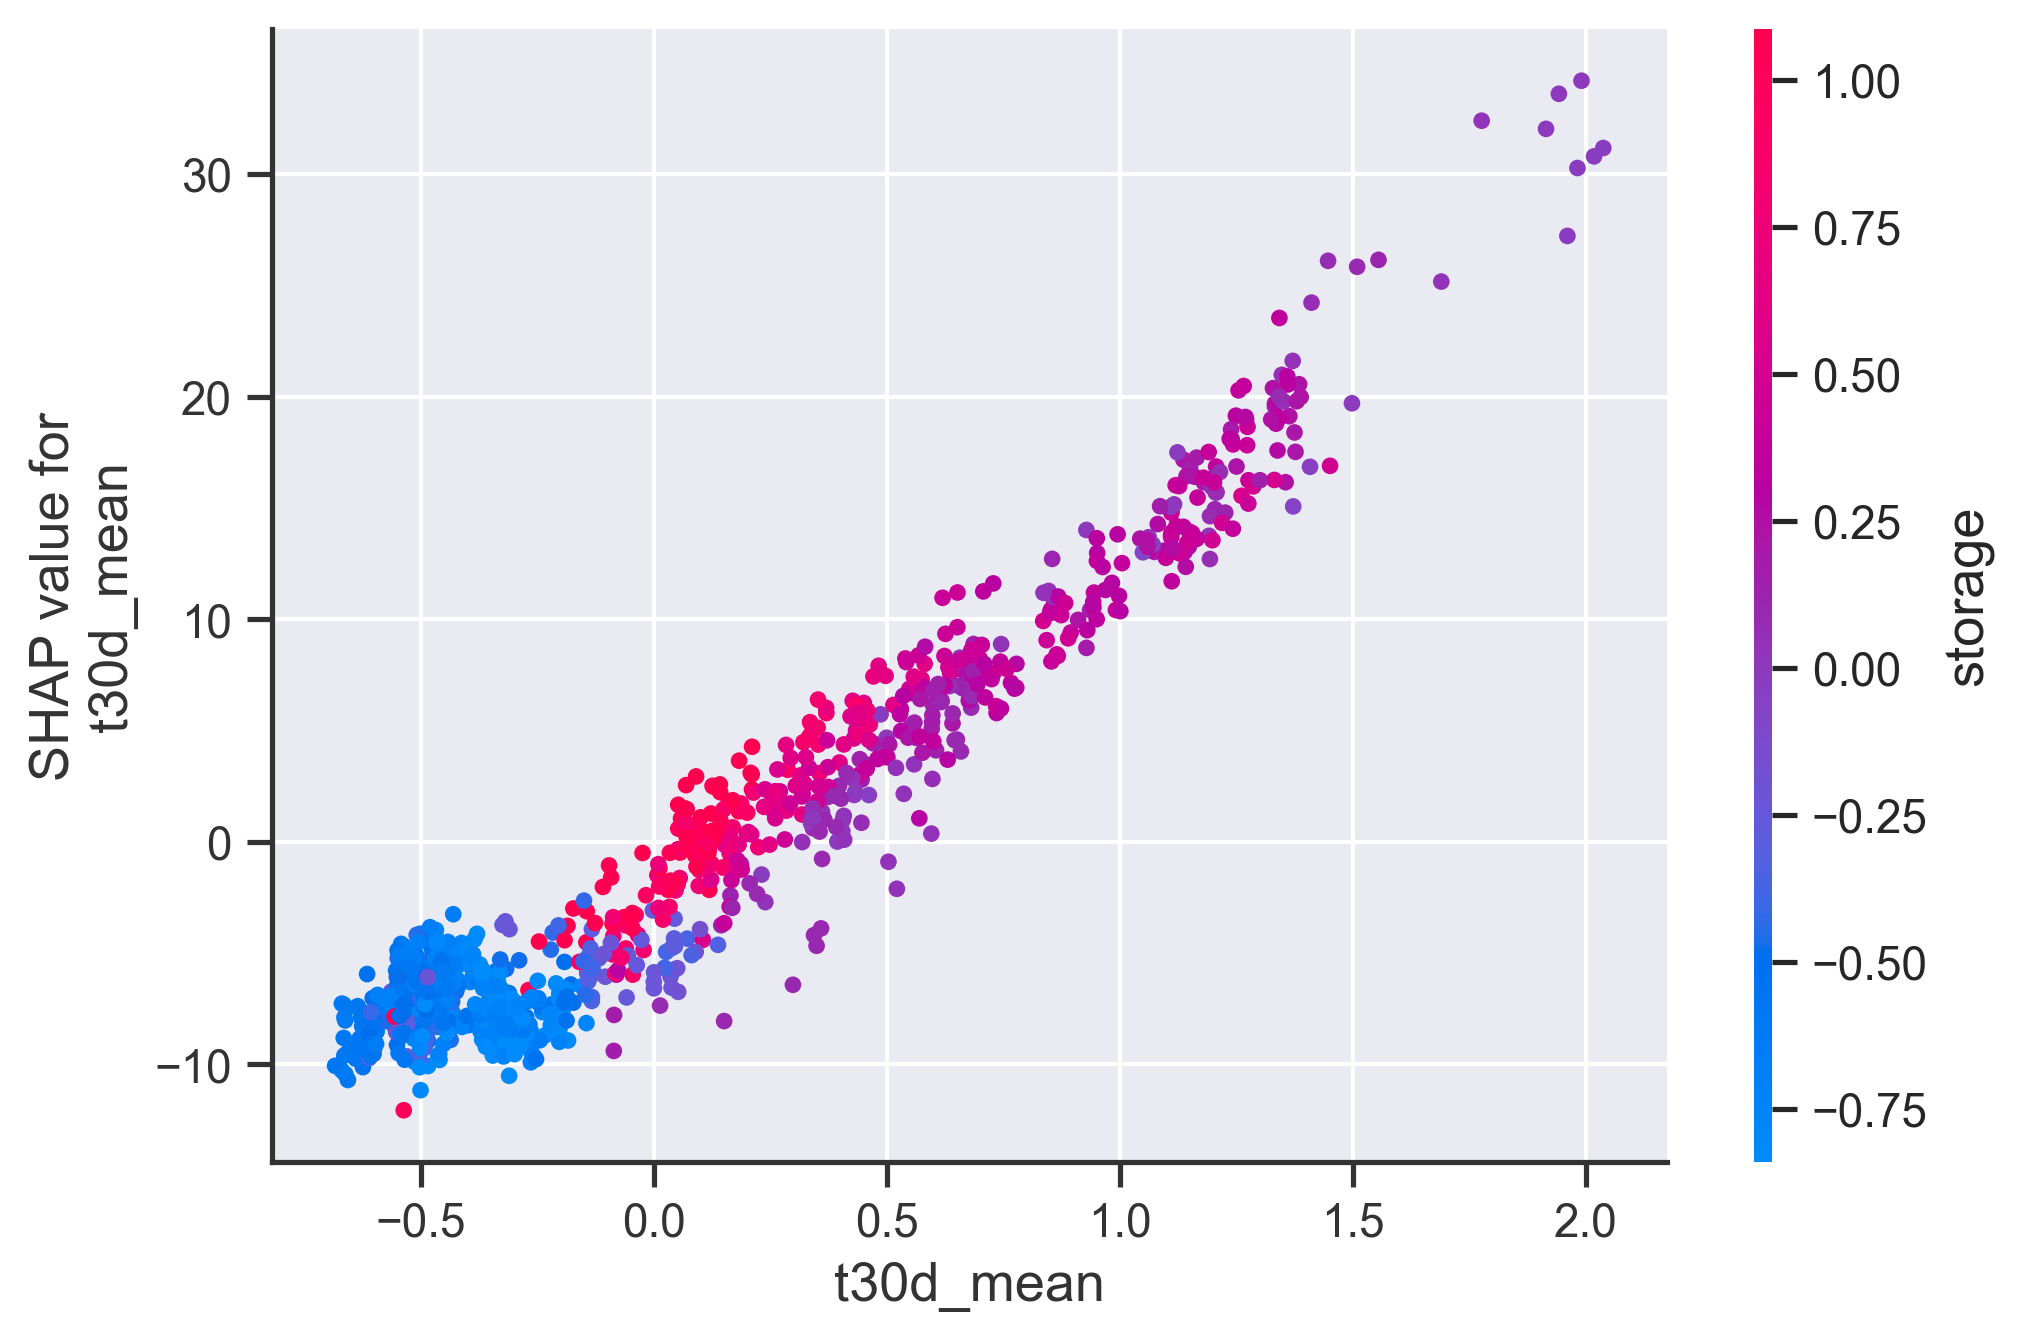

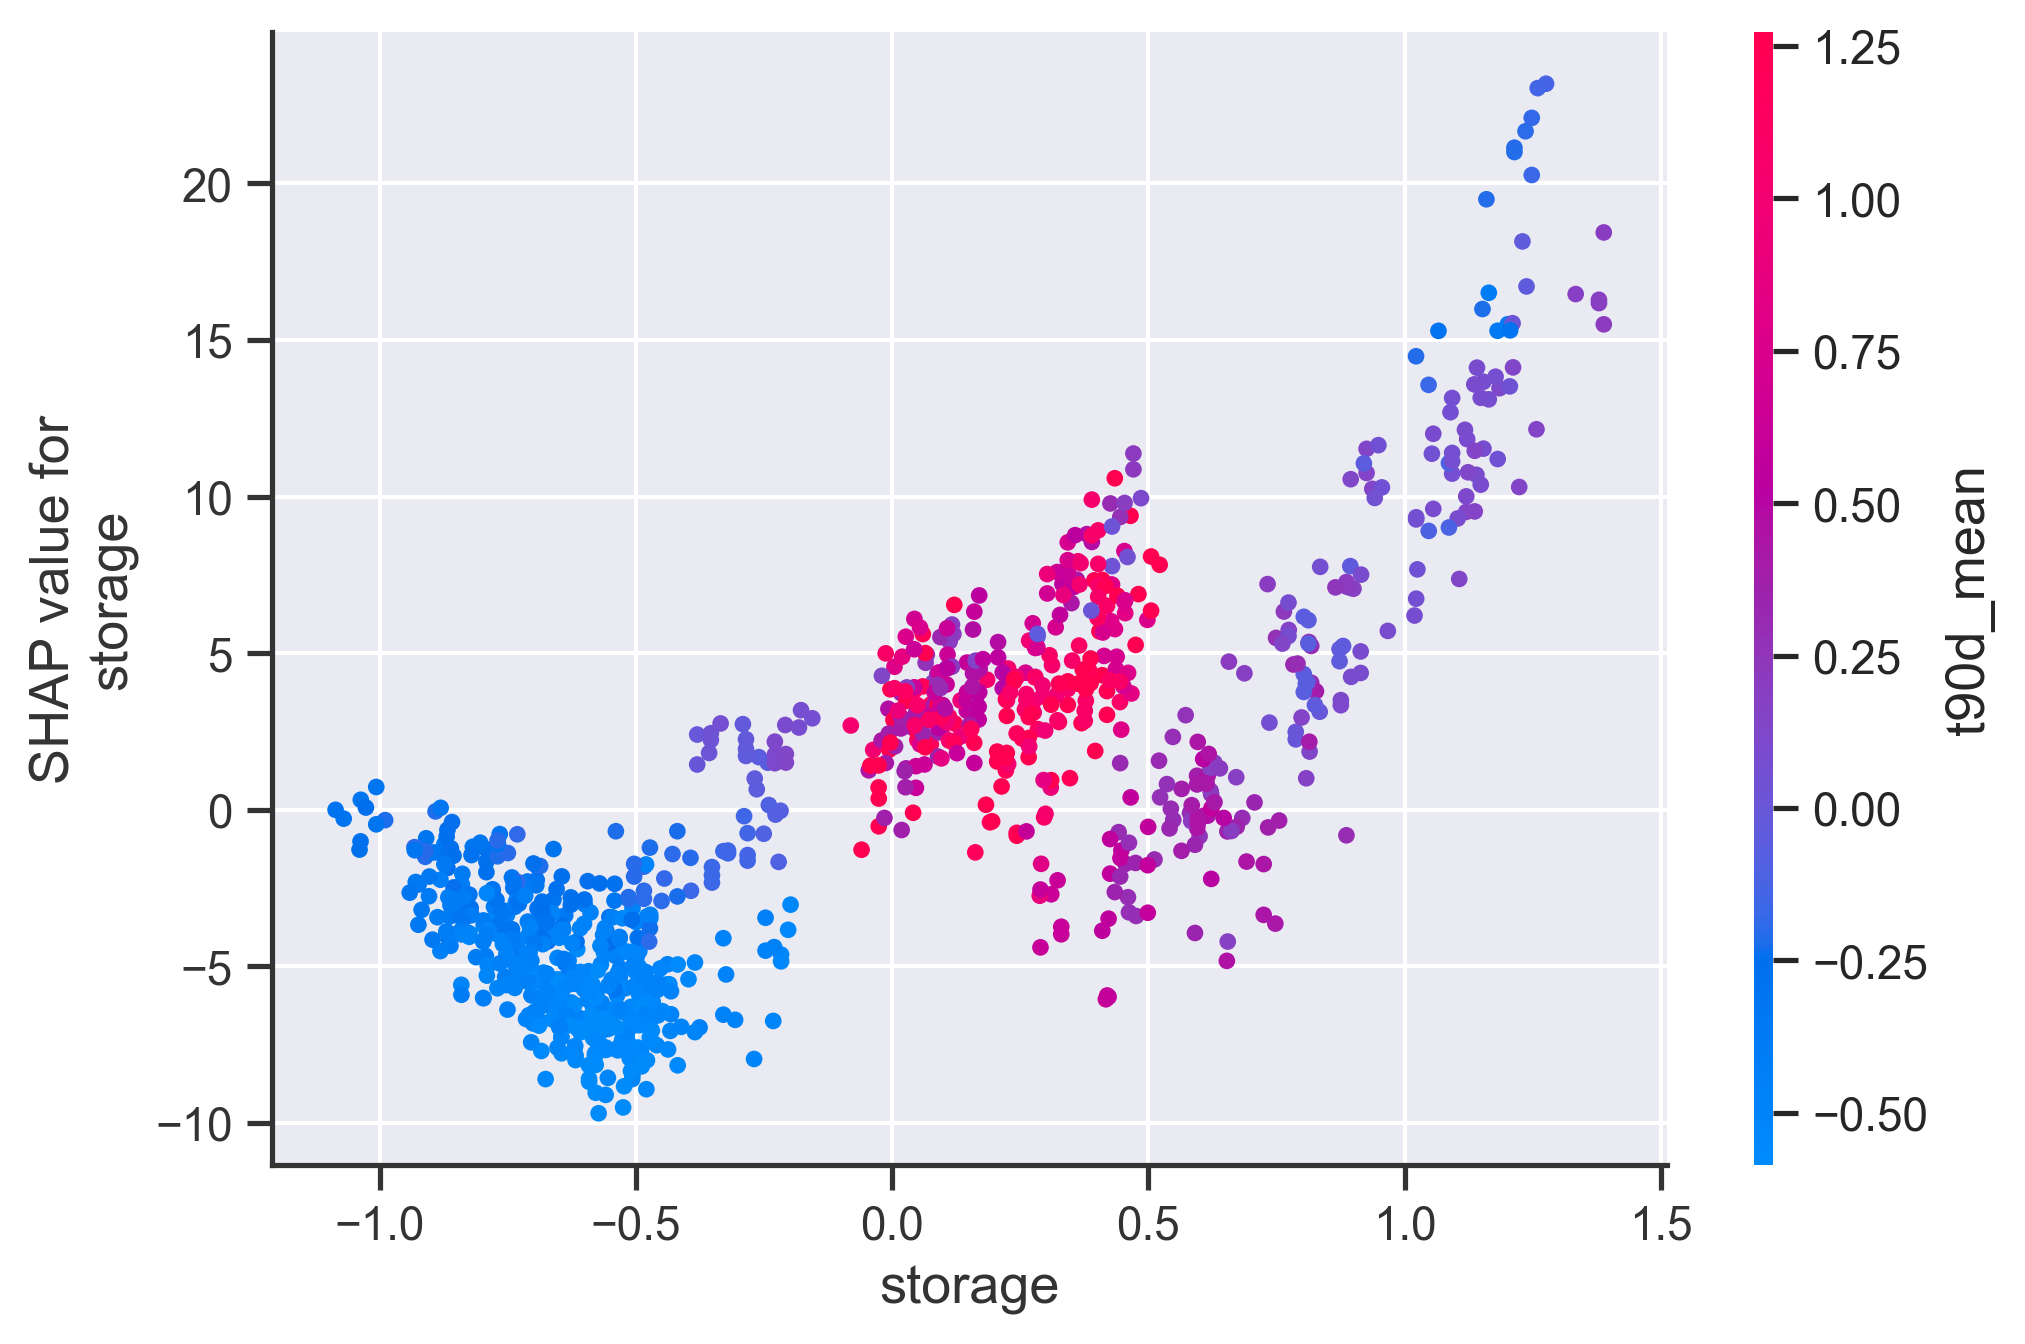

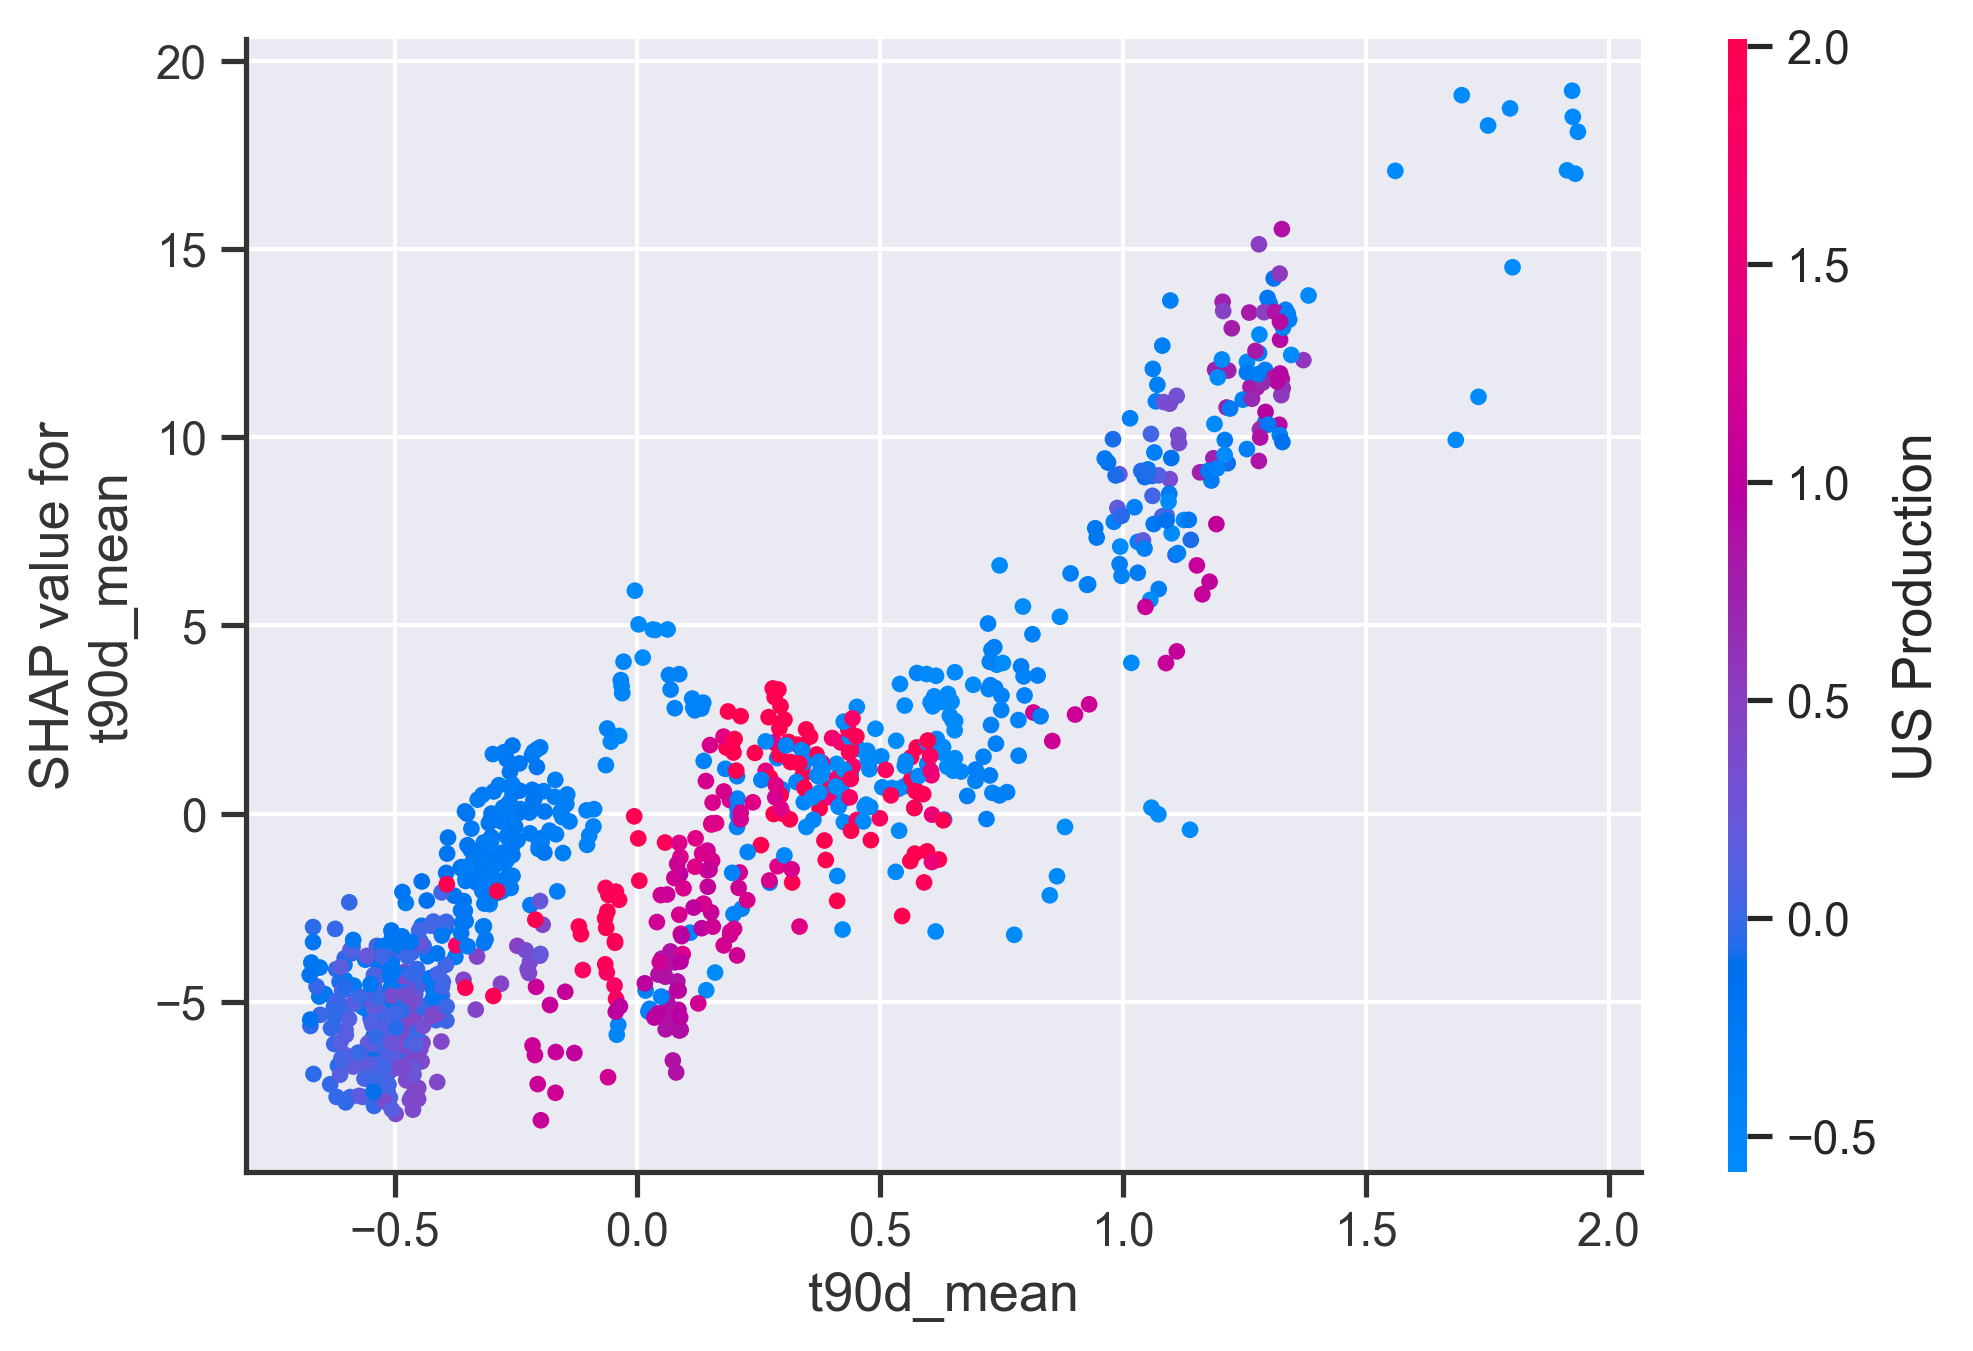

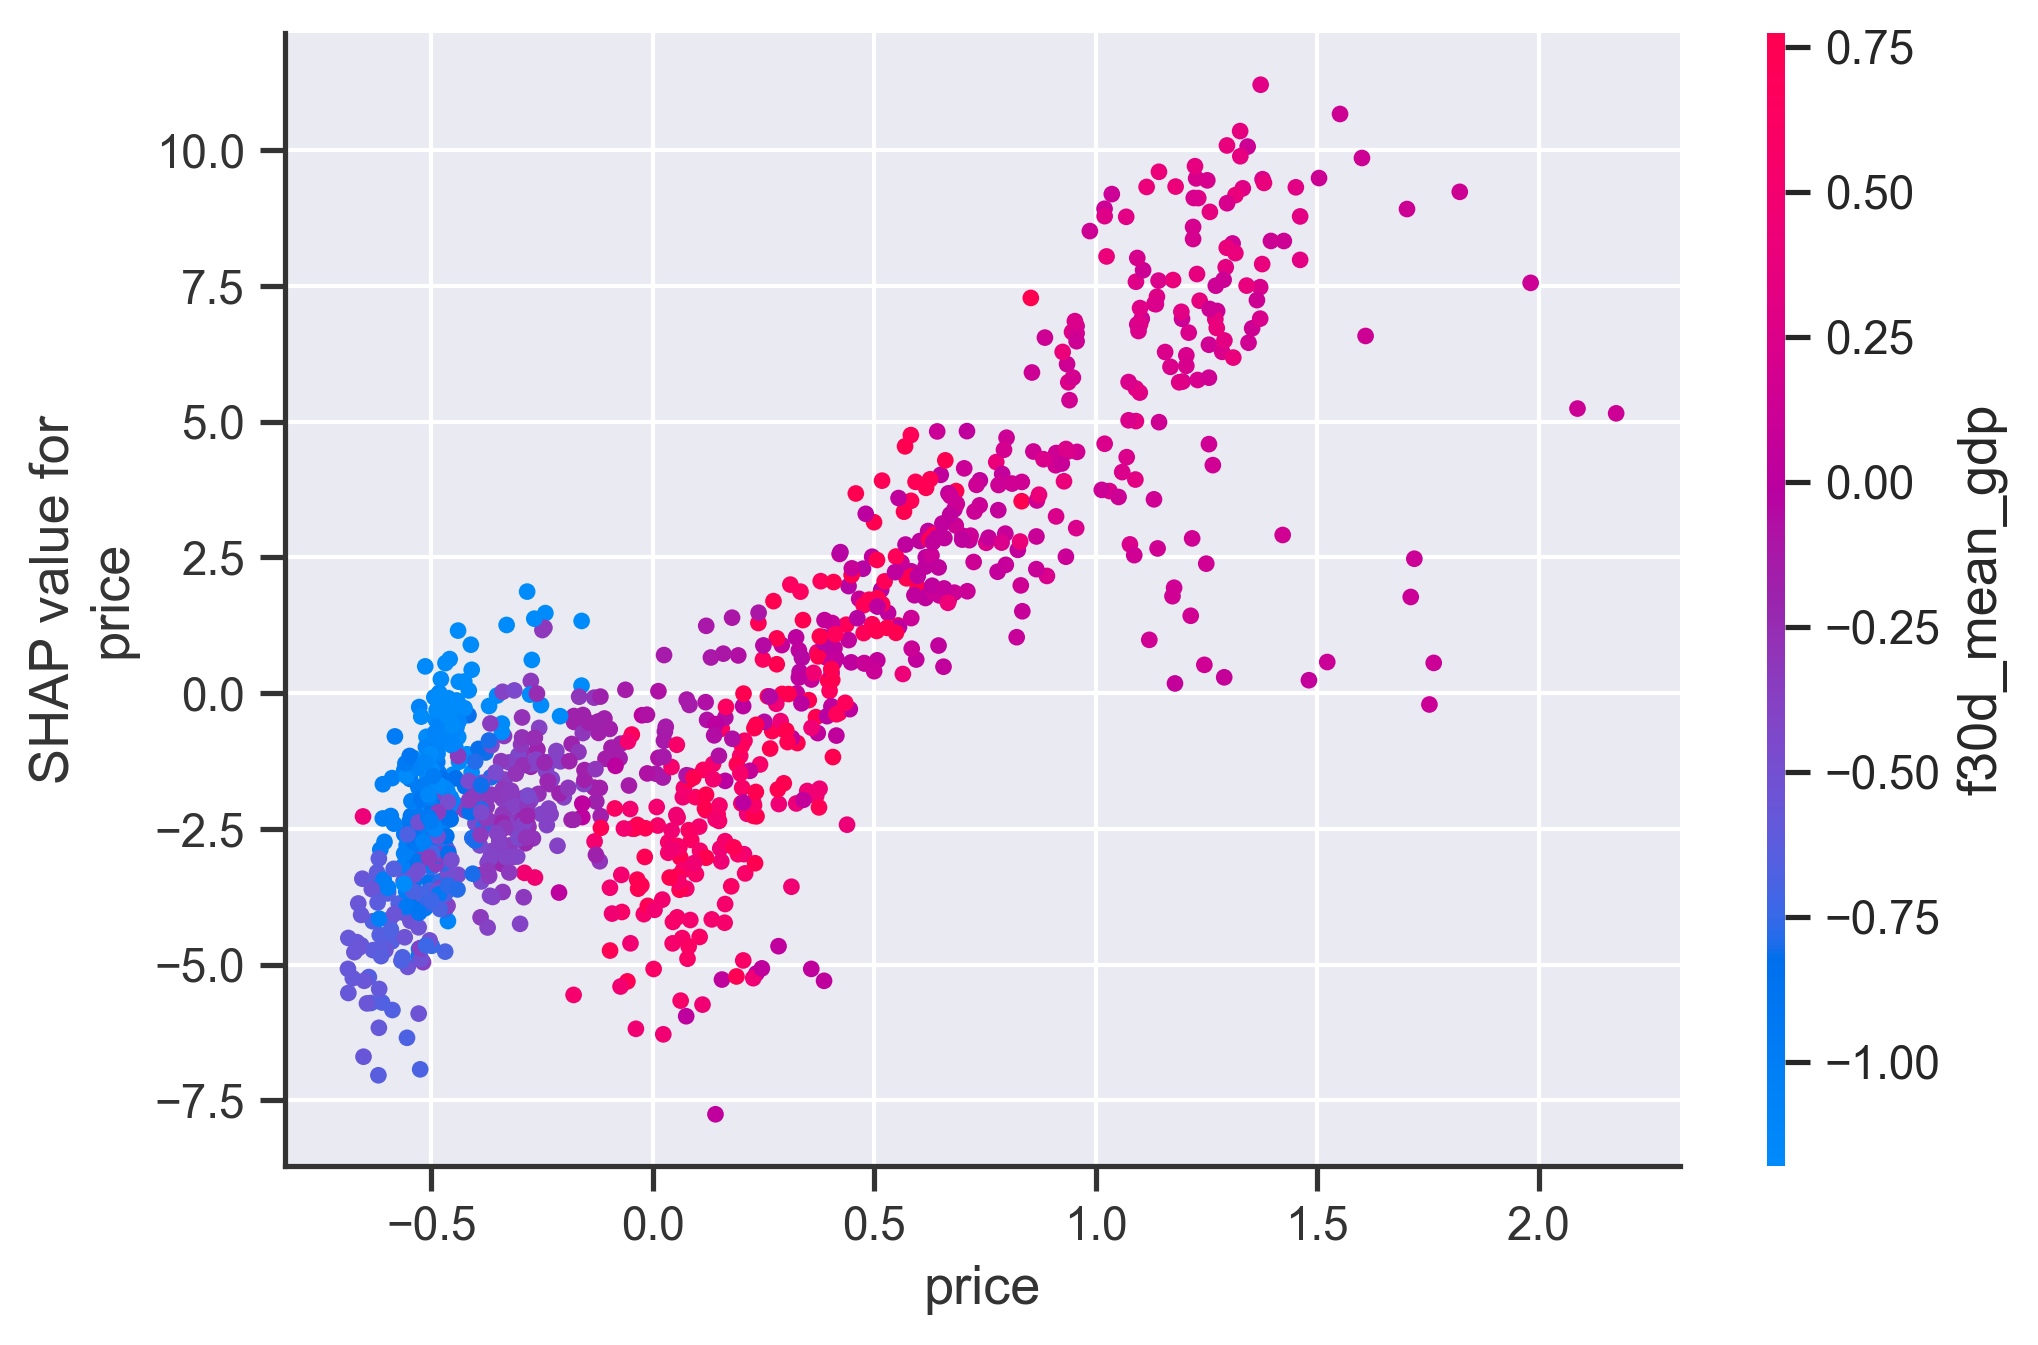

In [25]:
for i in range(len(X_test_shap.columns)):
    shap.dependence_plot("rank({})".format(i), shap_values[0], X_test_shap)

#### Force Plot

The most continuous response seems to be around current WTI price. The plot shows the upward (red) or downward (blue) "force" exerted by each feature in a given region of current WTI price.

Note the force plot relies on interactive features only visible in a working notebook.

In [26]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test_shap)